In [1]:
import os, gc, re, time, pickle
from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
os.listdir('../data/input')

['calendar.csv',
 'data.pkl',
 'prep_data.pkl',
 'sales_train_validation.csv',
 'sample_submission.csv',
 'sell_prices.csv']

In [3]:
%%time
with open('../data/input/data.pkl', 'rb') as f:
    df = pickle.load(f)

Wall time: 1min 52s


In [4]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  demand   part       date  wm_yr_wk event_name_1 event_type_1  \
0       CA       0  train 2011-01-29     11101          NaN          NaN   
1       CA       0  train 2011-01-29     11101          NaN          NaN   
2       CA       0  train 2011-01-29     11101          NaN          NaN   
3       CA       0  train 2011-01-29     11101          NaN          NaN   
4       CA       0  train 2011-01-29     11101          NaN          NaN   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0          NaN          NaN        0        0        0         NaN  
1          NaN          NaN        0        0        0         NaN  
2          NaN          NaN        0        0        0         NaN  
3          NaN          NaN        0        0        0         NaN  
4          NaN          NaN        0        0        0         NaN

In [5]:
print(df[df['part'] == 'train']['date'].min())
print(df[df['part'] == 'train']['date'].max())

2011-01-29 00:00:00
2016-04-24 00:00:00


In [5]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [7]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  demand   part       date  wm_yr_wk event_name_1 event_type_1  \
0       CA       0  train 2011-01-29     11101          NaN          NaN   
1       CA       0  train 2011-01-29     11101          NaN          NaN   
2       CA       0  train 2011-01-29     11101          NaN          NaN   
3       CA       0  train 2011-01-29     11101          NaN          NaN   
4       CA       0  train 2011-01-29     11101          NaN          NaN   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  year  \
0          NaN          NaN        0        0        0         NaN  2011   
1          NaN          NaN        0        0        0         NaN  2011   
2          NaN          NaN        0        0        0         NaN  2011   
3          NaN          NaN        0        0        0         NaN  2011   
4          NaN          NaN        0        0        0         NaN  2011   

   month  weekday  
0      1        5  
1      1        5  
2      1        5  
3      1        5  
4      1        5

In [6]:
# Label
event_col = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for c in event_col:
    df[c] = df[c].fillna('Nodata')
    df[c + '_l'] = df[c].apply(lambda x: 0 if x == 'Nodata' else -1)

In [7]:
train = df[df['part'] == 'train']
# val = df[df['part'] == 'test1']
# eval = df[df['part'] == 'test2']
del df
gc.collect()

78

---
## Date

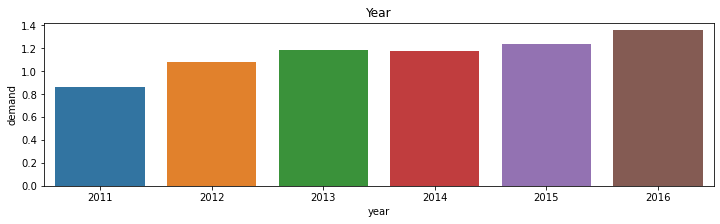

In [10]:
# Year
group = train.groupby(['year'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.barplot(x='year', y='demand', data=group)
plt.title('Year')
plt.show()

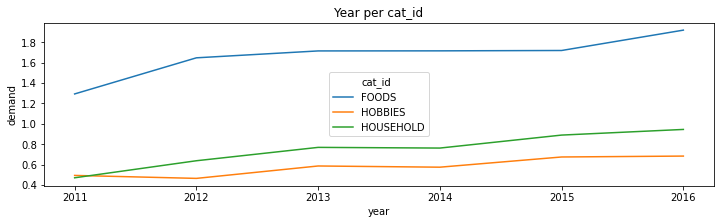

In [11]:
# Year, cat_id
group = train.groupby(['year', 'cat_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='year', y='demand', hue='cat_id', data=group)
plt.title('Year per cat_id')
plt.show()

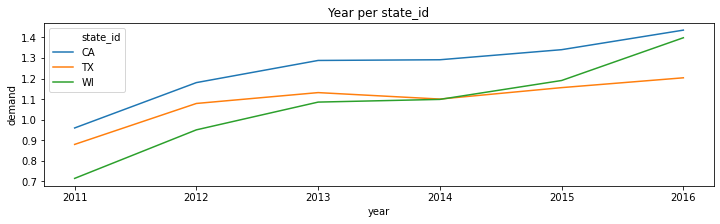

In [12]:
group = train.groupby(['year', 'state_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='year', y='demand', hue='state_id', data=group)
plt.title('Year per state_id')
plt.show()

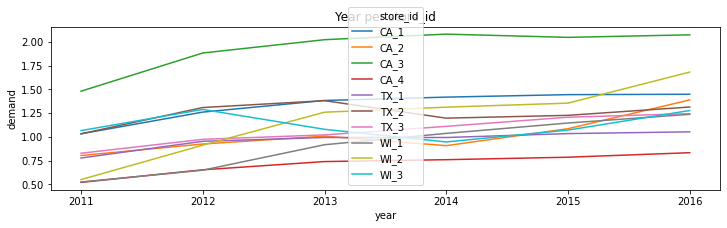

In [13]:
group = train.groupby(['year', 'store_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='year', y='demand', hue='store_id', data=group)
plt.title('Year per store_id')
plt.show()

---
Month

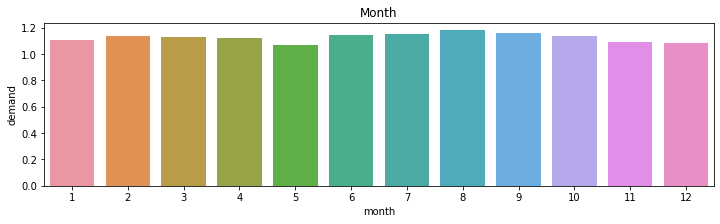

In [14]:
group = train.groupby(['month'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.barplot(x='month', y='demand', data=group)
plt.title('Month')
plt.show()

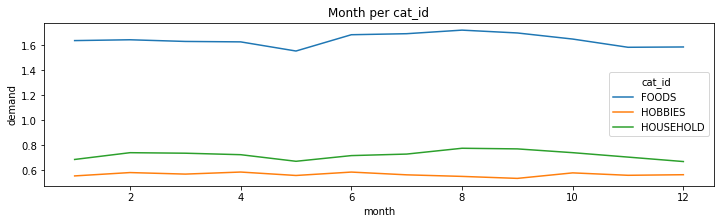

In [15]:
group = train.groupby(['month', 'cat_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='month', y='demand', hue='cat_id', data=group)
plt.title('Month per cat_id')
plt.show()

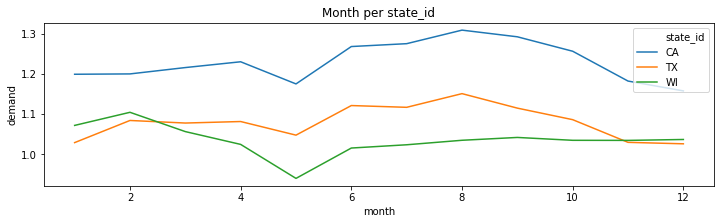

In [16]:
group = train.groupby(['month', 'state_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='month', y='demand', hue='state_id', data=group)
plt.title('Month per state_id')
plt.show()

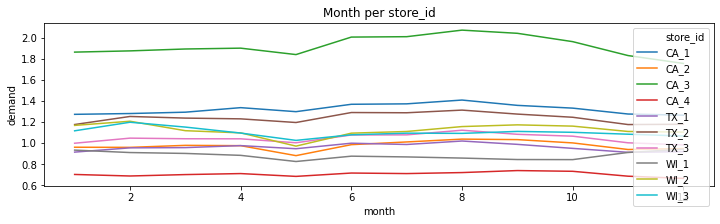

In [17]:
group = train.groupby(['month', 'store_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='month', y='demand', hue='store_id', data=group)
plt.title('Month per store_id')
plt.show()

---
Weekday

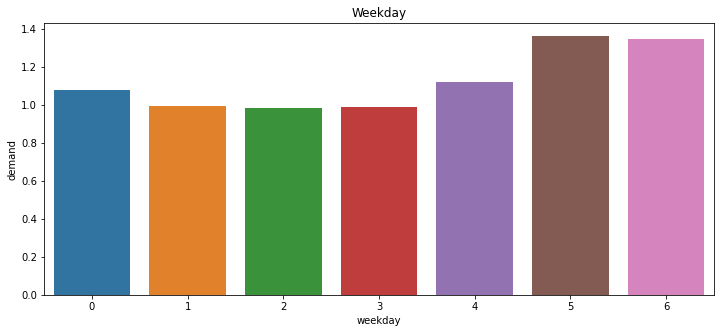

In [18]:
group = train.groupby(['weekday'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.barplot(x='weekday', y='demand', data=group)
plt.title('Weekday')
plt.show()

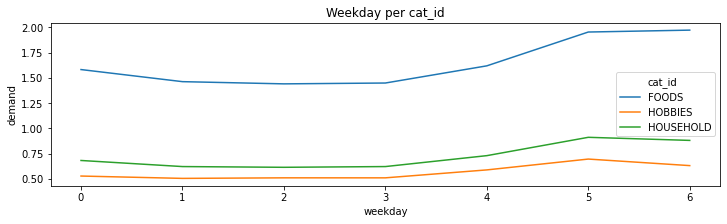

In [19]:
group = train.groupby(['weekday', 'cat_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='weekday', y='demand', hue='cat_id', data=group)
plt.title('Weekday per cat_id')
plt.show()

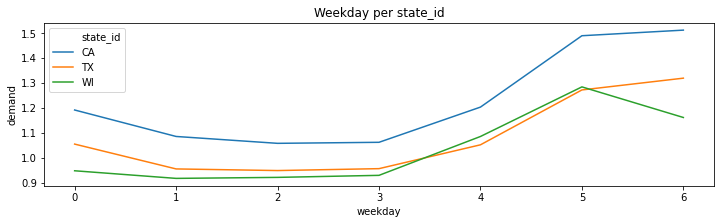

In [20]:
group = train.groupby(['weekday', 'state_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='weekday', y='demand', hue='state_id', data=group)
plt.title('Weekday per state_id')
plt.show()

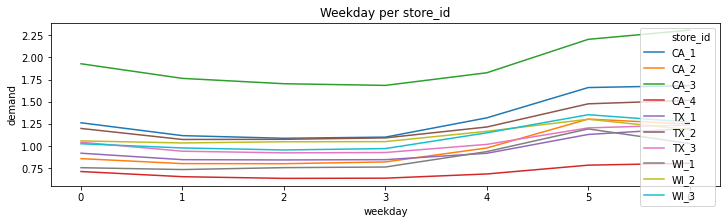

In [21]:
group = train.groupby(['weekday', 'store_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='weekday', y='demand', hue='store_id', data=group)
plt.title('Weekday per store_id')
plt.show()

In [22]:
print(train[train['event_type_1_l'] != 0]['date'].nunique())
print(train['date'].nunique())

154
1913


---
## Plot

In [23]:
def plot(df, id):
    """
    IDごとのプロット
    """
    temp = df[df['id'] == id]
    temp.sort_values(by='date', ascending=True, inplace=True)
    
    fig, ax1 = plt.subplots(figsize=(14, 3), facecolor='w')
    ax2 = ax1.twinx()
    ax1.plot(temp['date'], temp['demand'], color='b', label='demand')
    ax1.plot(temp['date'], temp['event_name_1_l'], color='g', label='isEvent')
    ax2.plot(temp['date'], temp['sell_price'], color='r', label='sell_price')
    # 第２軸の範囲を設定
    ax2.set_ylim(temp['sell_price'].min() - 0.5, temp['sell_price'].max() + 0.5)
    # 凡例
    # グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
    plt.title(id)
    plt.show()
    
    
def plot_per_item(df, item):
    """
    item_idを入れるとstoreごとのプロットを抽出する
    """
    
    tar_col = [c for c in df['id'].values if item in c]
    
    fig, axes = plt.subplots(5, 2, figsize=(12, 18))
    
    for i, (t, ax) in enumerate(zip(tar_col, axes.ravel())):        
        temp = df[df['id'] == t]
        temp.sort_values(by='date', ascending=True, inplace=True)
        
        ax2 = ax.twinx()
        ax.plot(temp['date'], temp['demand'], color='b', label='demand')
        ax.plot(temp['date'], temp['event_name_1_l'], color='g', label='isEvent')
        ax2.plot(temp['date'], temp['sell_price'], color='r', label='sell_price')
        # 第２軸の範囲を設定
        ax2.set_ylim(temp['sell_price'].min() - 0.5, temp['sell_price'].max() + 0.5)
        # 凡例
        # グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
        handler1, label1 = ax.get_legend_handles_labels()
        handler2, label2 = ax2.get_legend_handles_labels()
        # 凡例をまとめて出力する
        ax.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
        ax.set_title(t)
        
    plt.tight_layout()

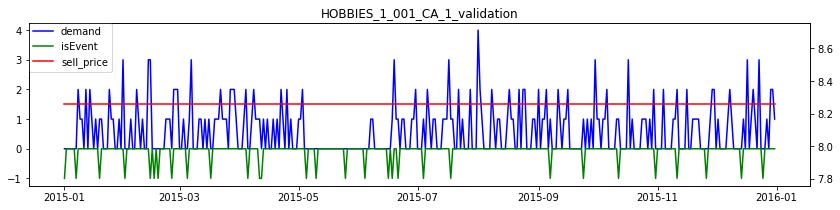

In [24]:
ids = train['id'].unique()
plot(train[train['year'] == 2015], ids[0])

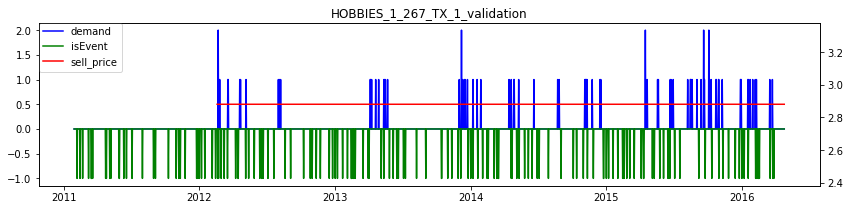

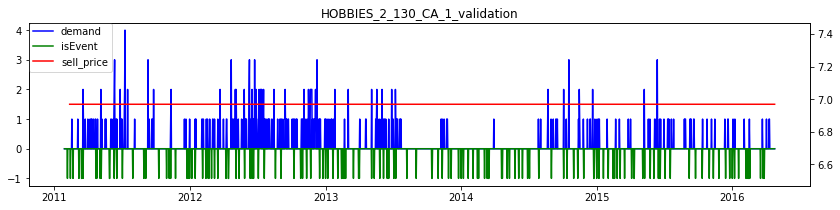

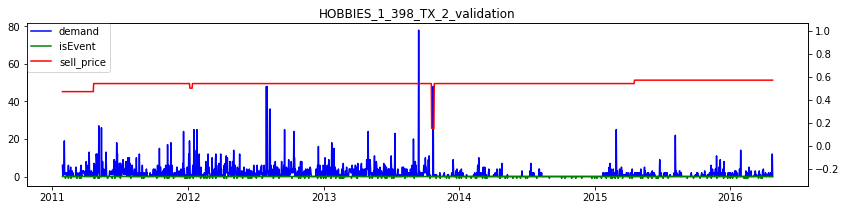

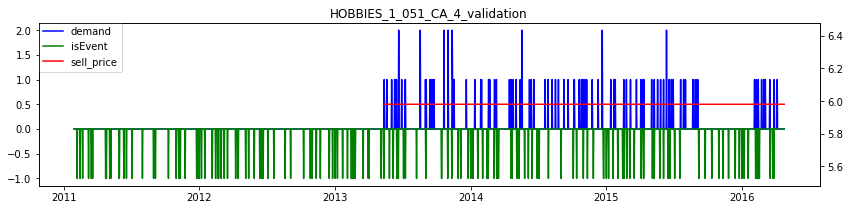

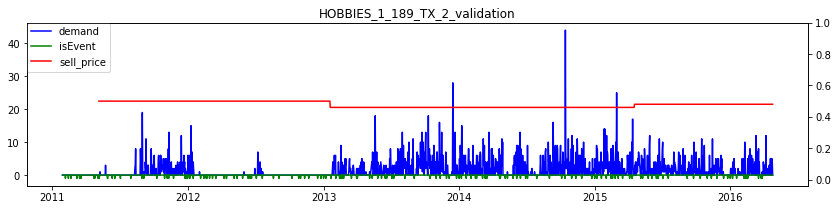

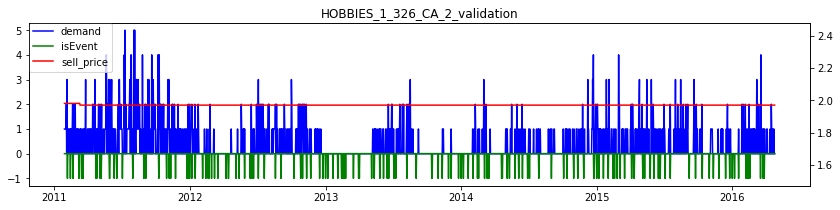

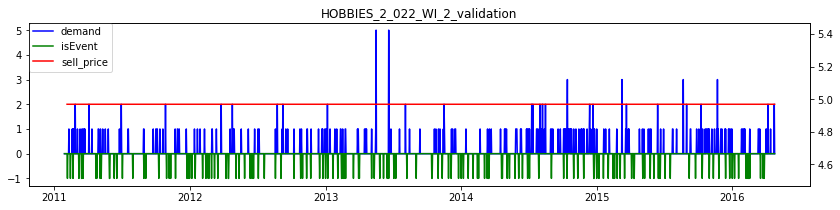

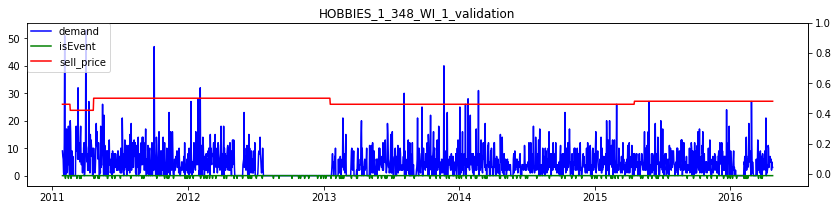

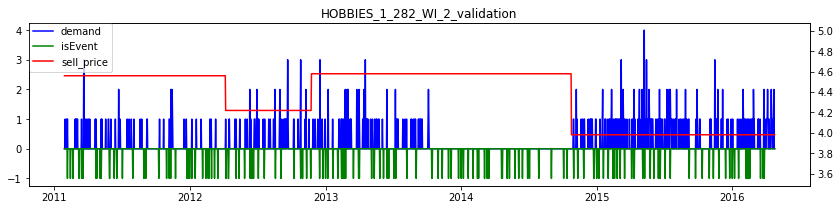

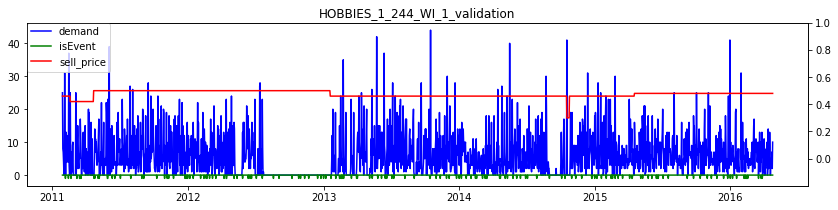

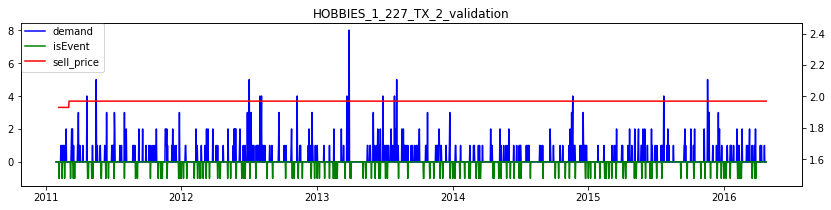

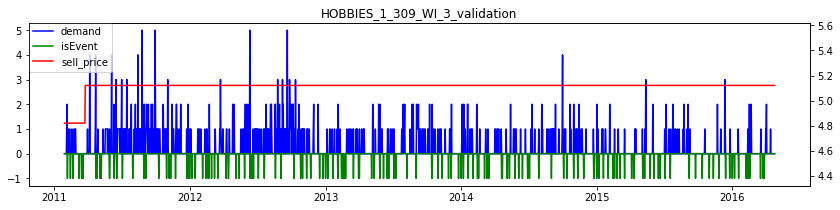

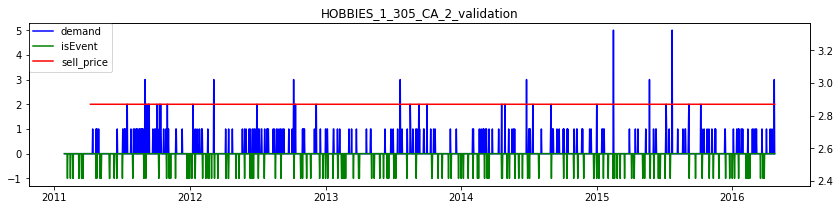

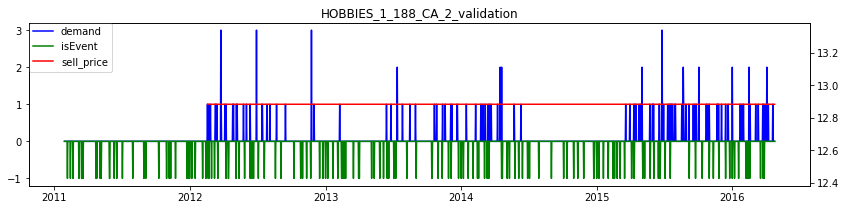

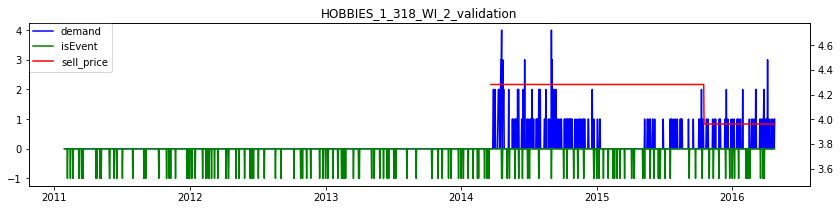

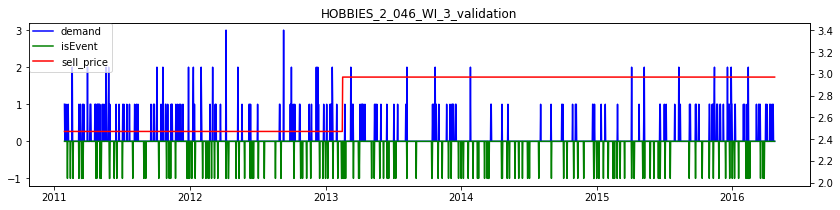

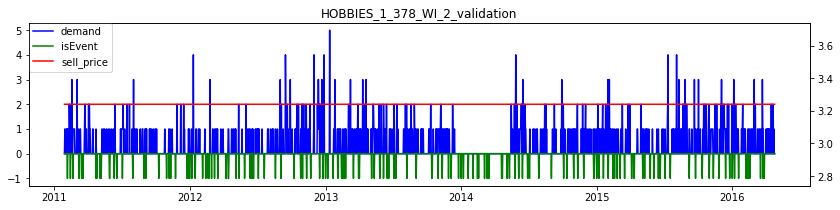

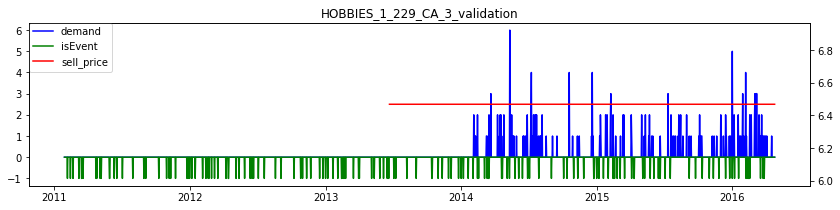

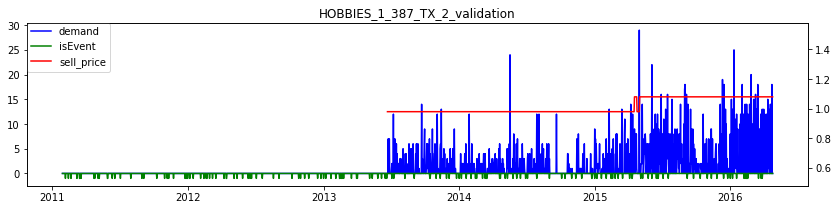

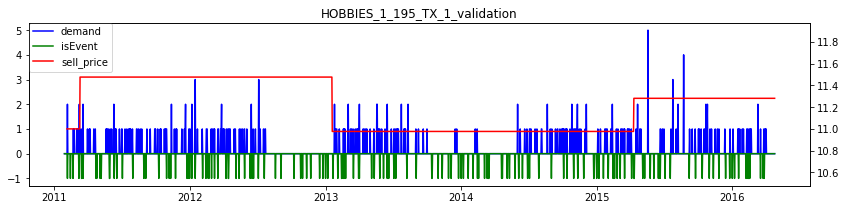

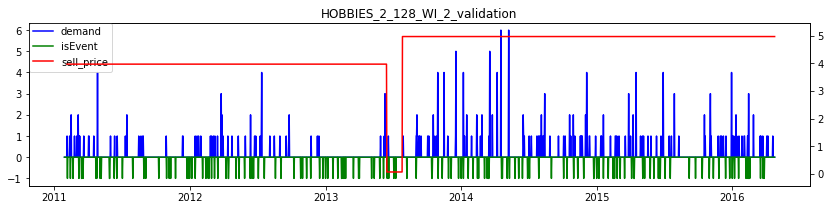

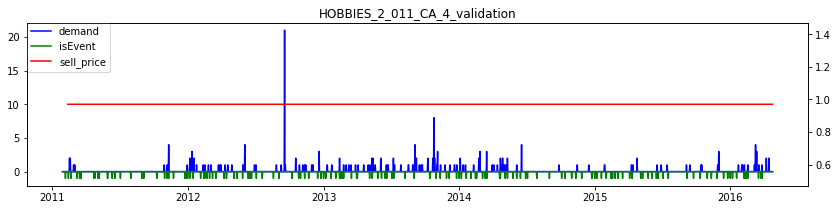

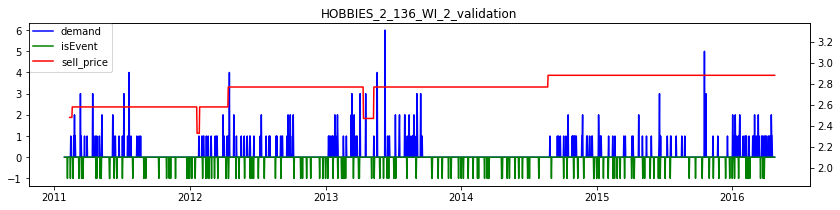

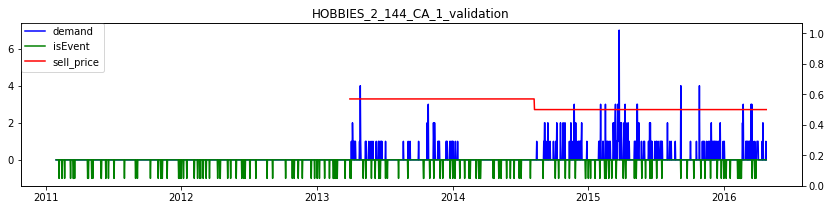

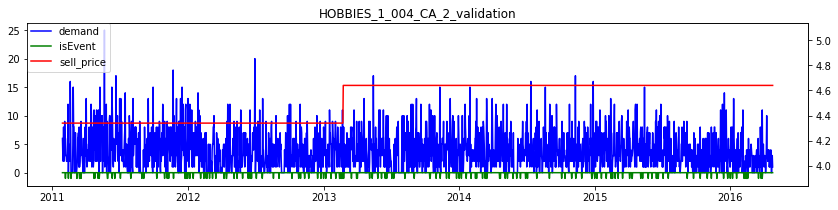

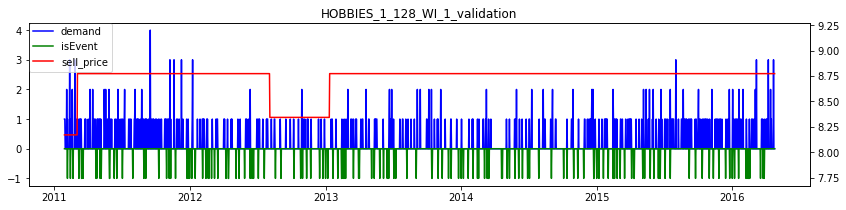

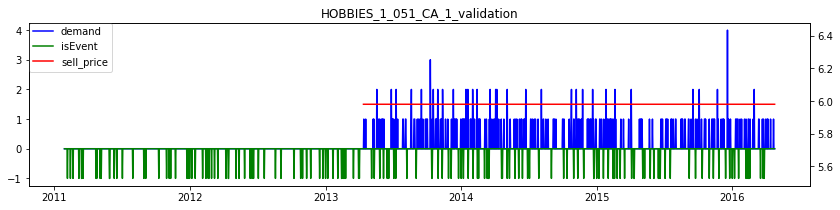

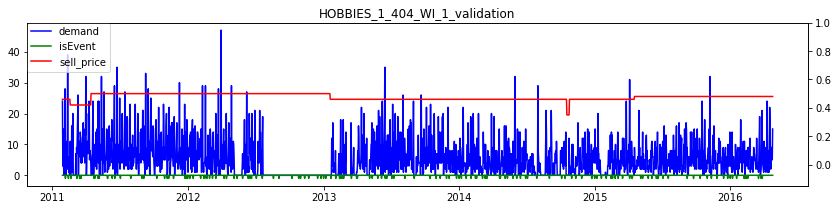

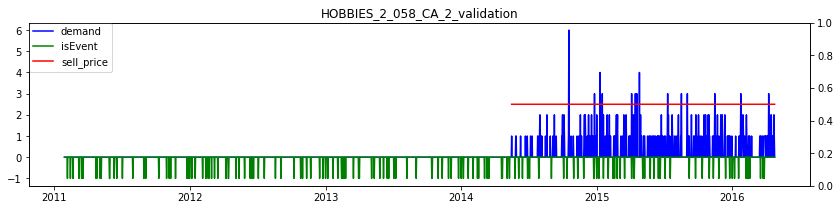

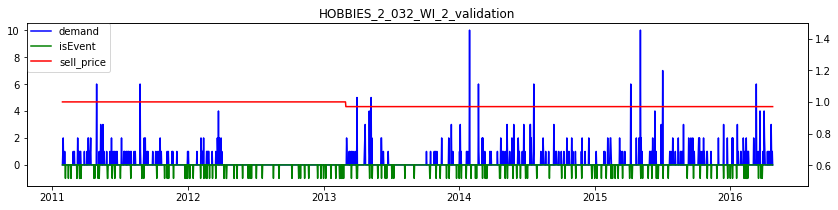

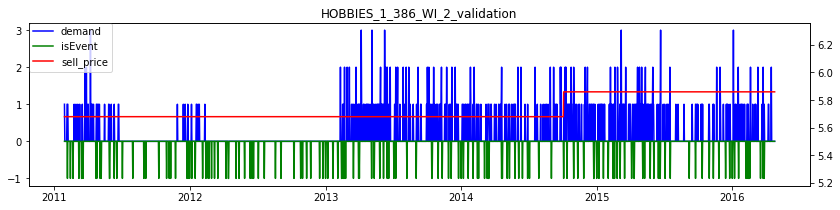

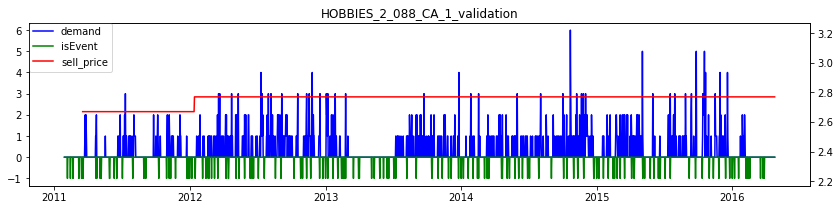

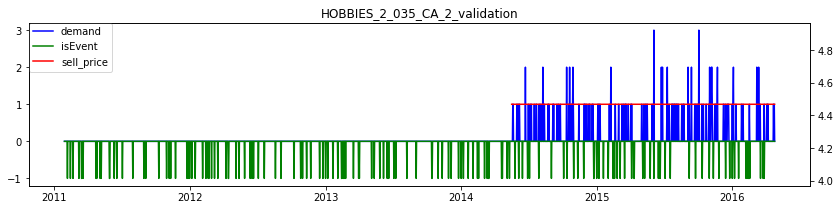

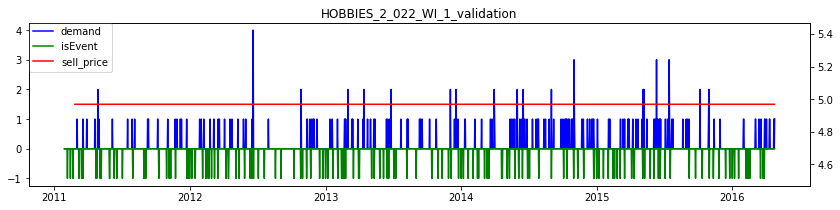

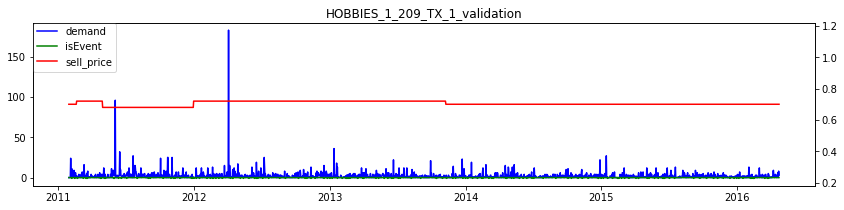

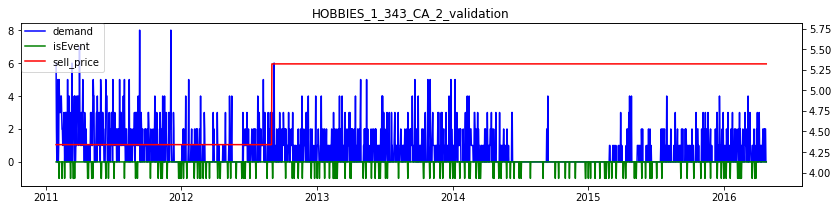

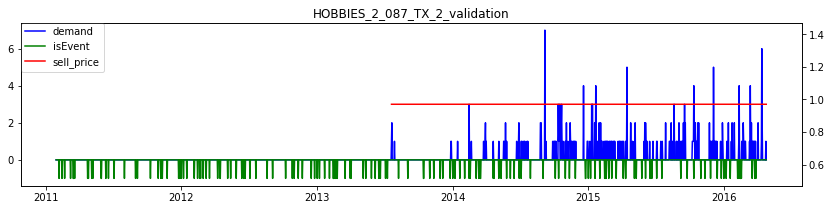

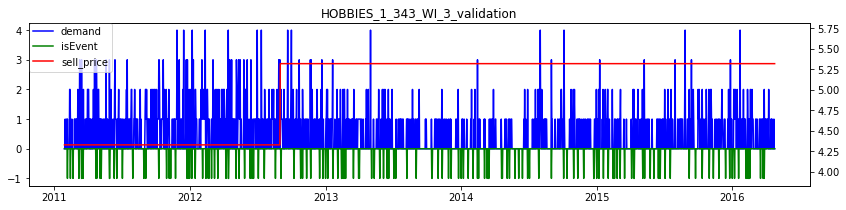

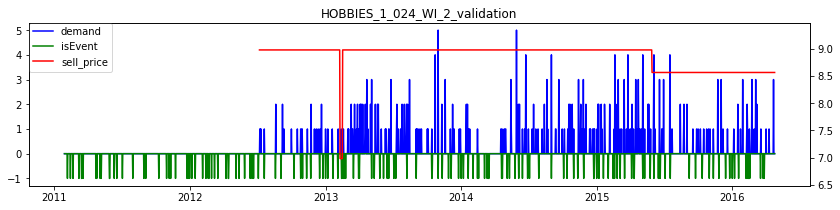

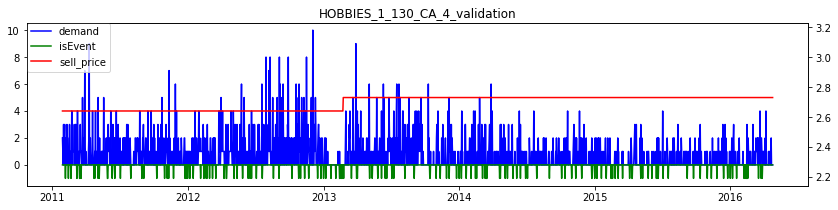

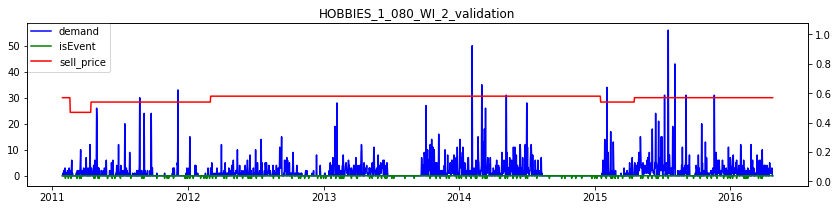

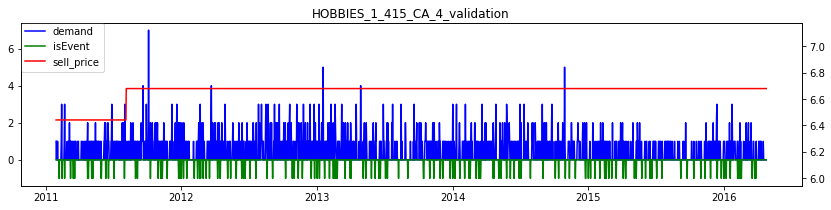

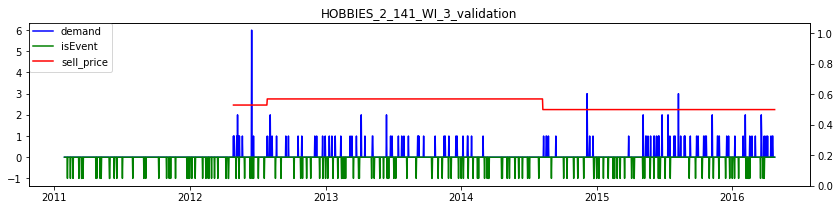

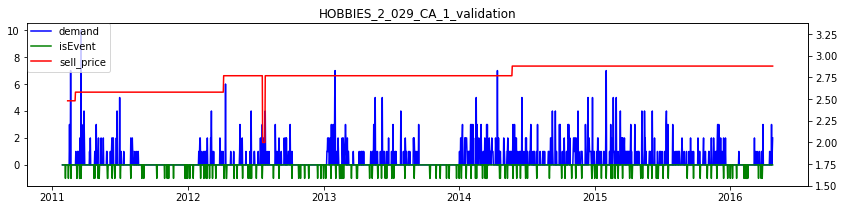

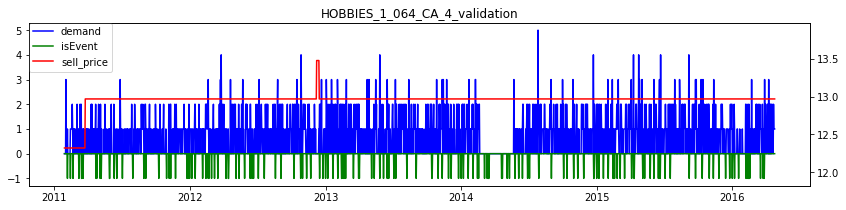

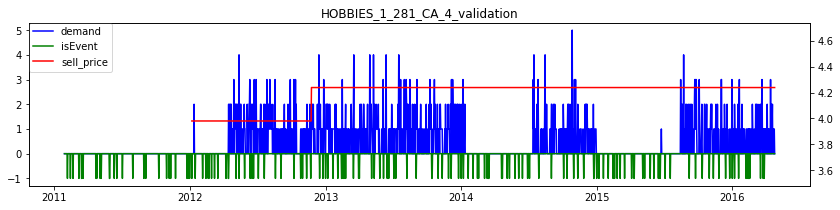

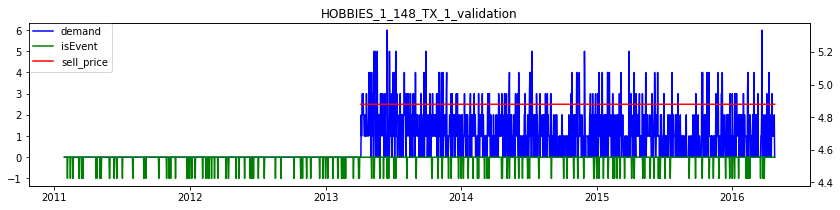

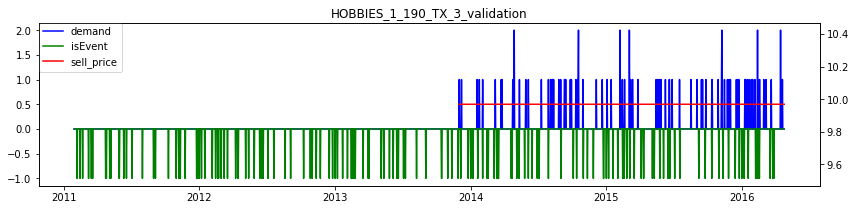

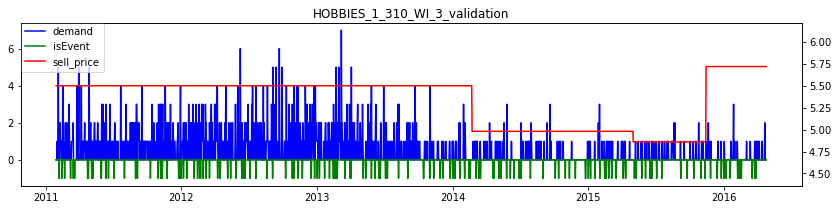

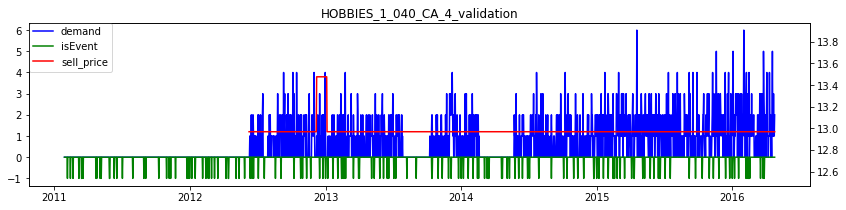

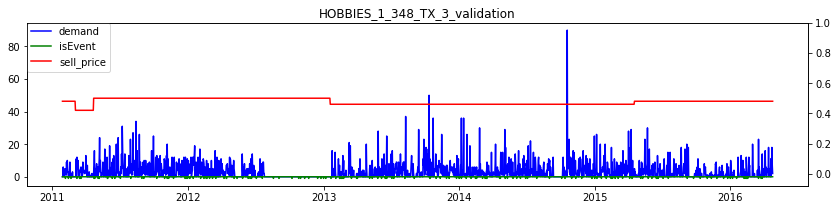

In [25]:
hobbie_id = [id for id in ids if 'HOBBIES' in id]
for i in range(len(hobbie_id)):
    r = np.random.randint(1, len(hobbie_id))
    plot(train, hobbie_id[r])
    if i == 50:
        break

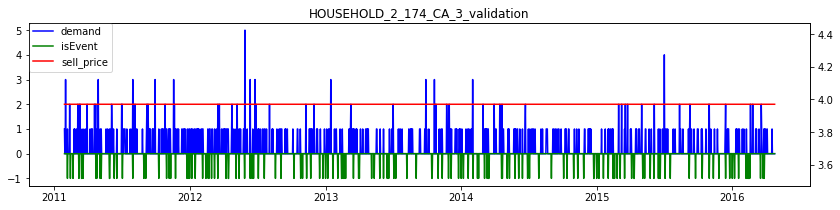

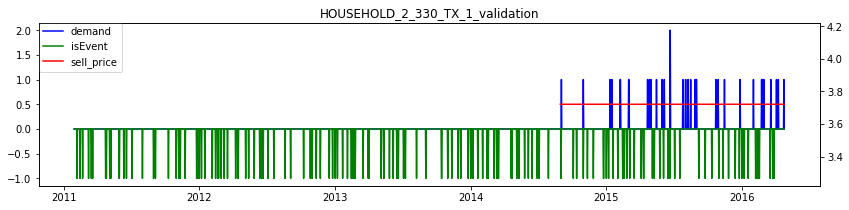

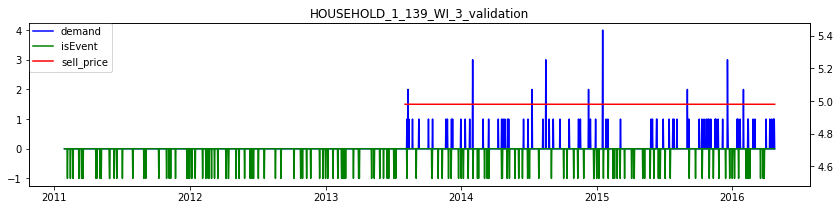

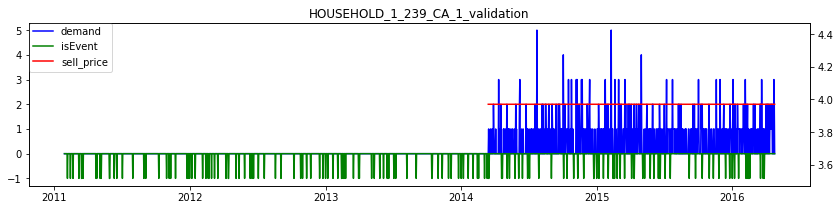

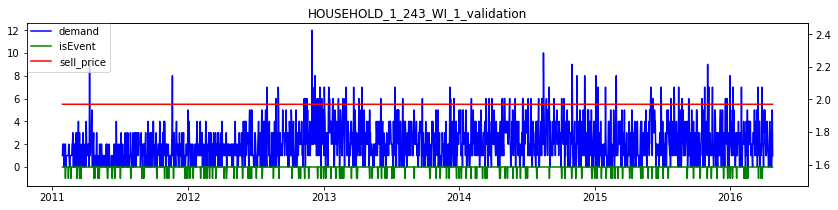

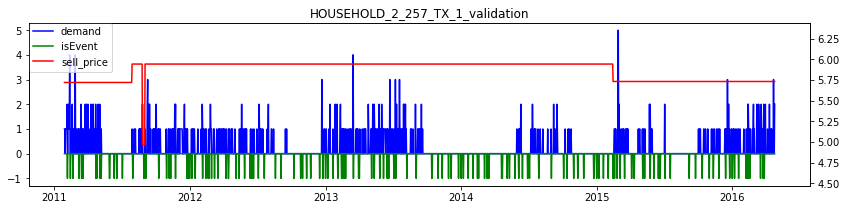

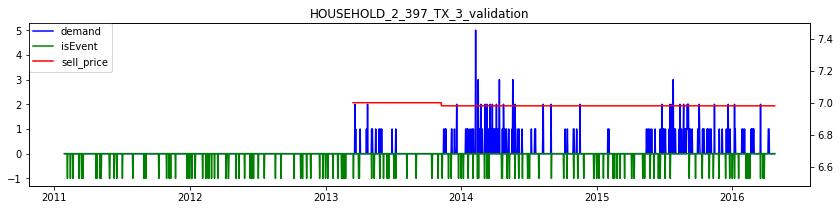

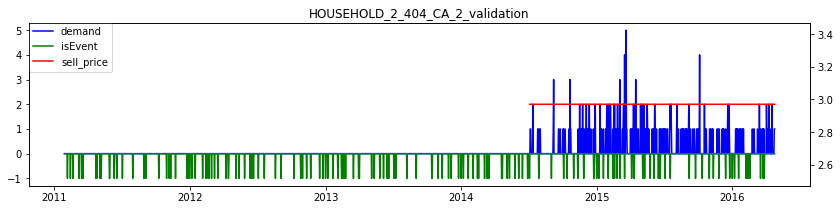

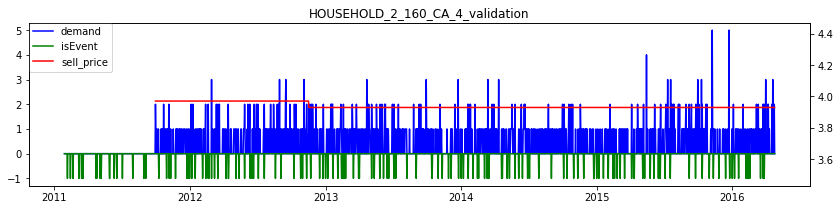

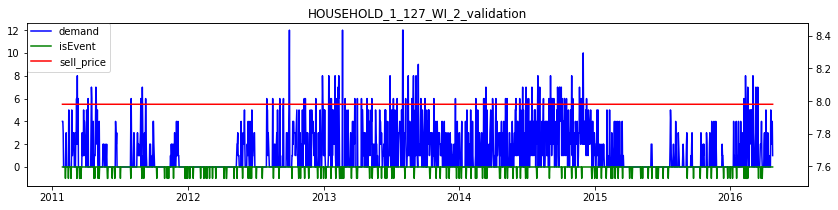

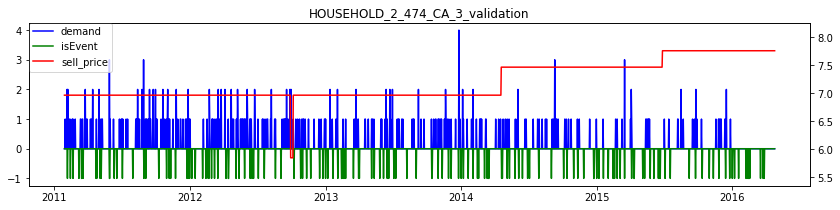

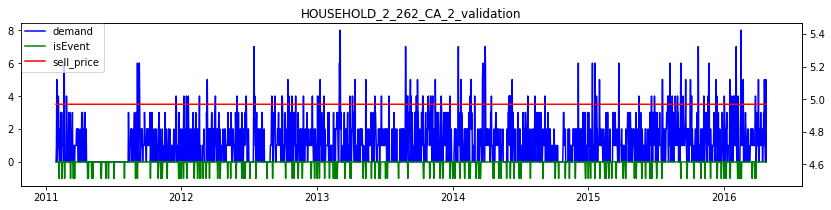

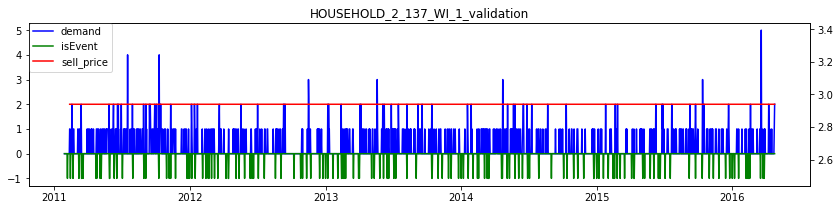

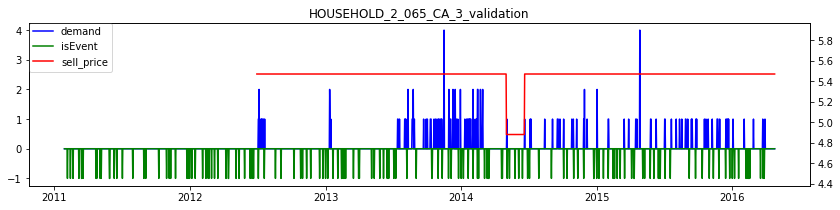

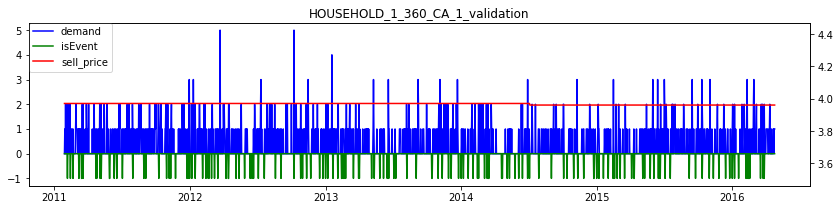

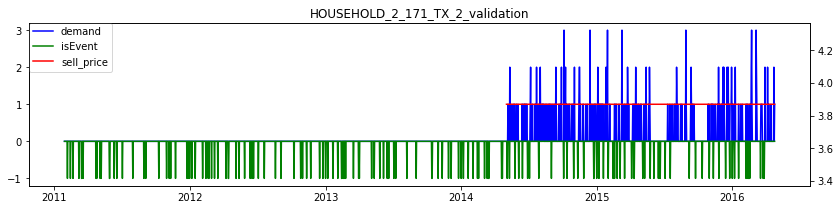

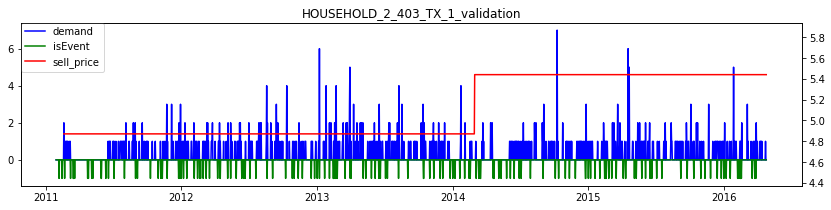

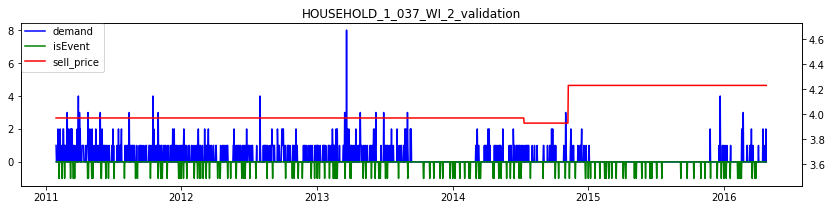

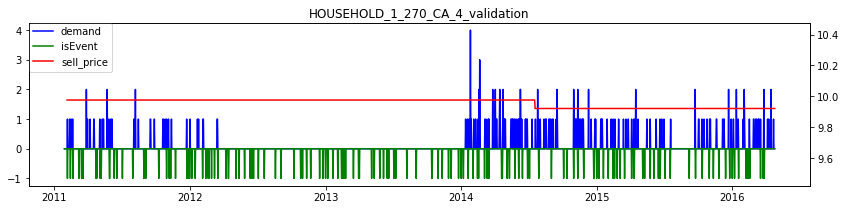

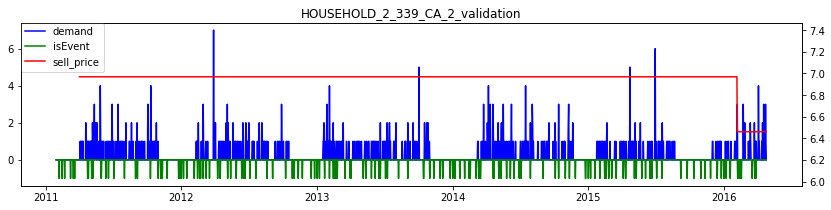

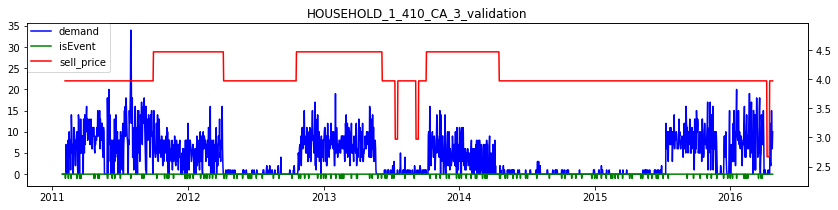

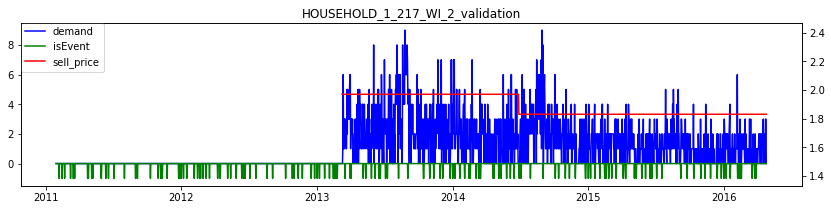

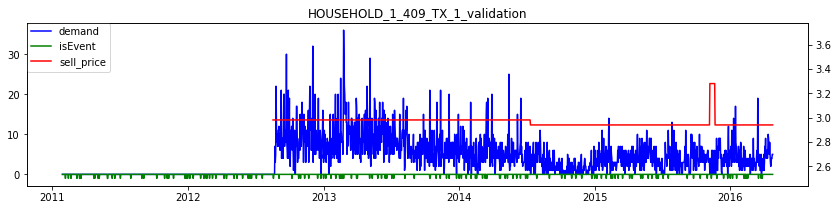

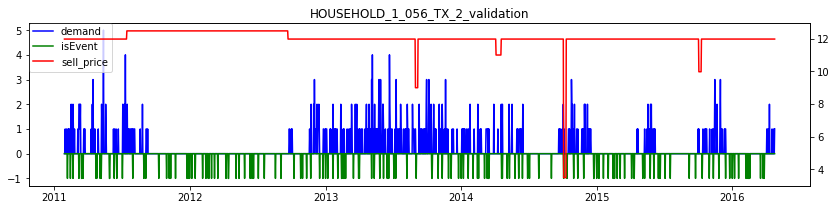

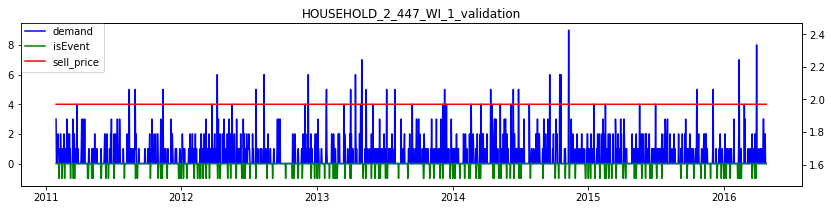

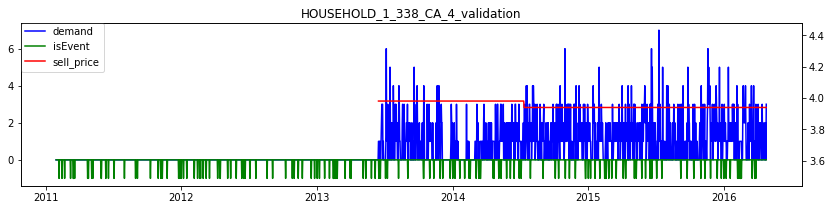

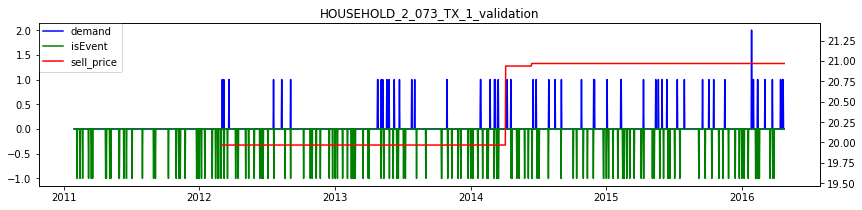

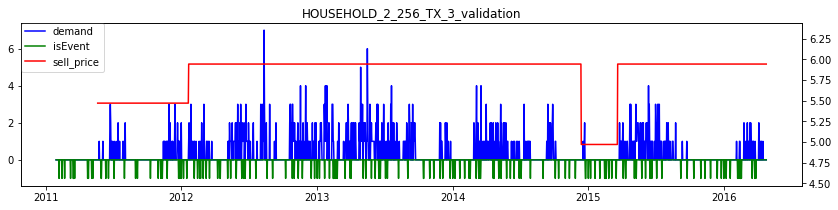

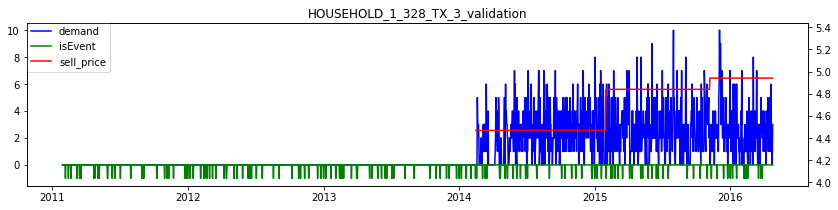

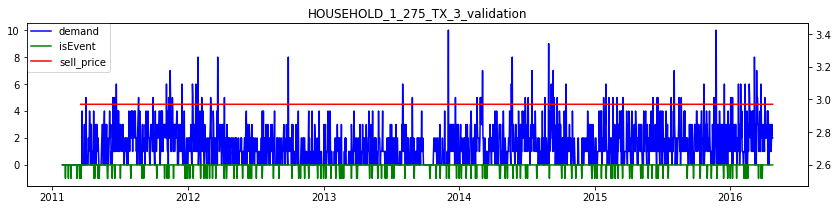

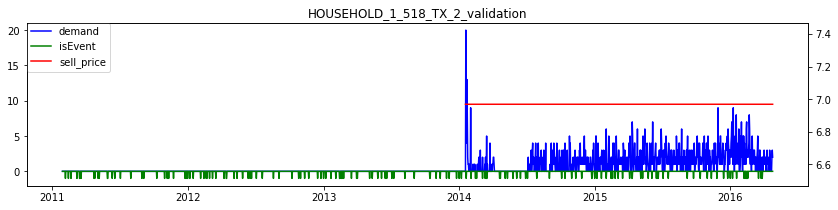

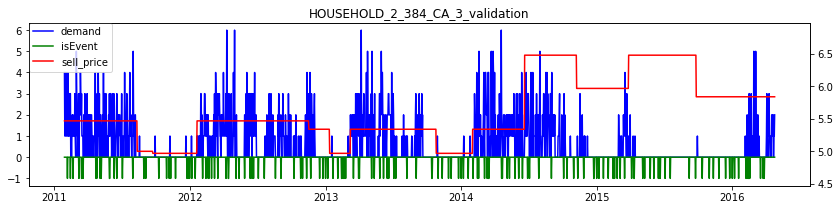

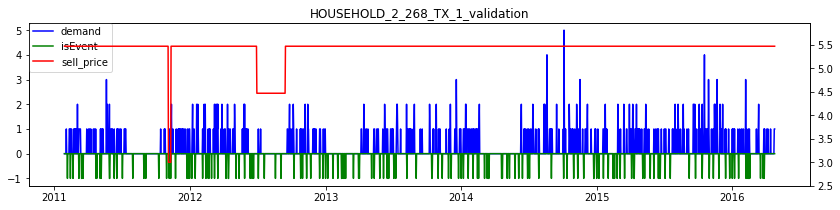

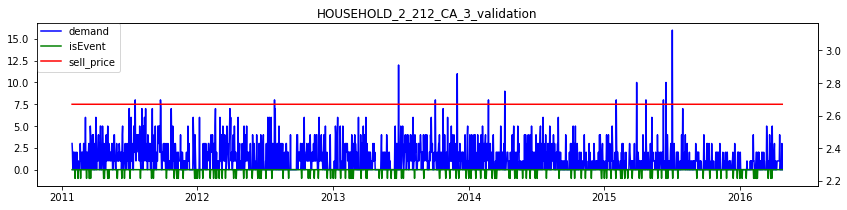

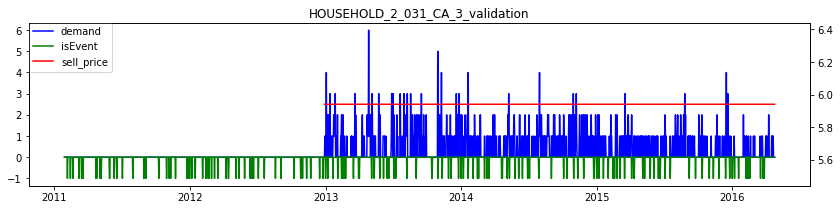

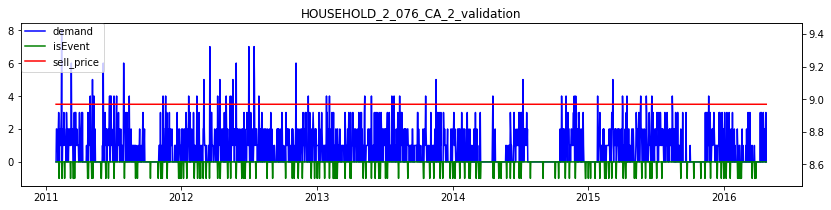

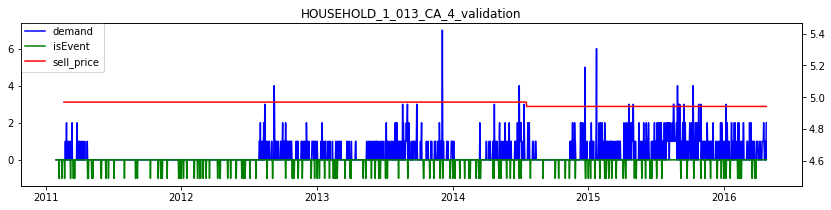

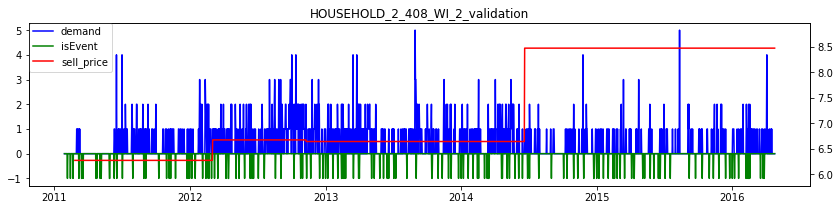

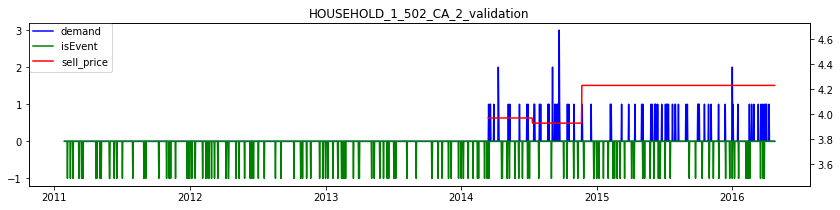

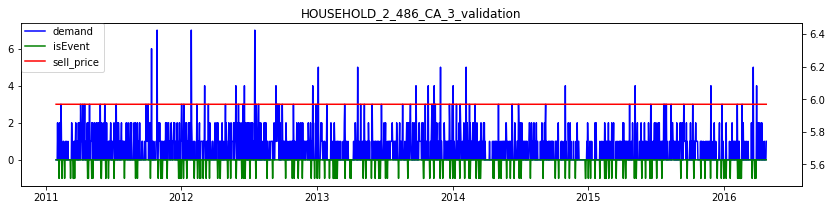

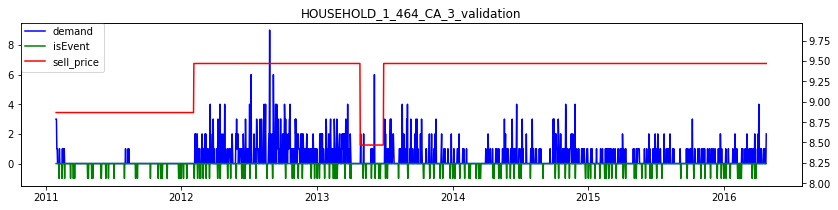

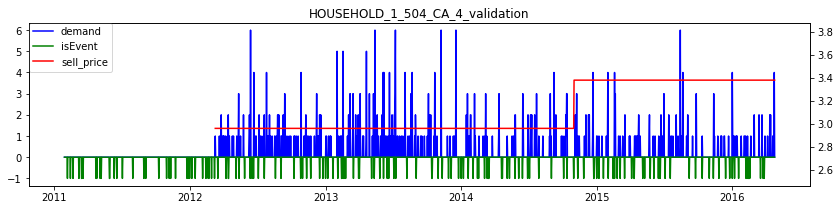

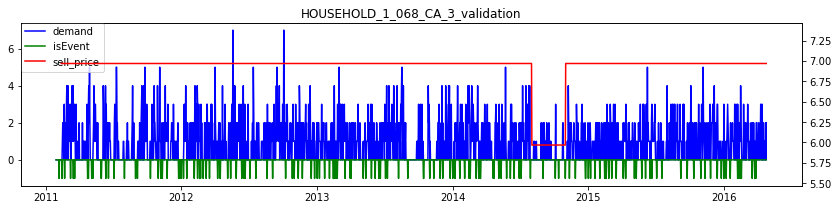

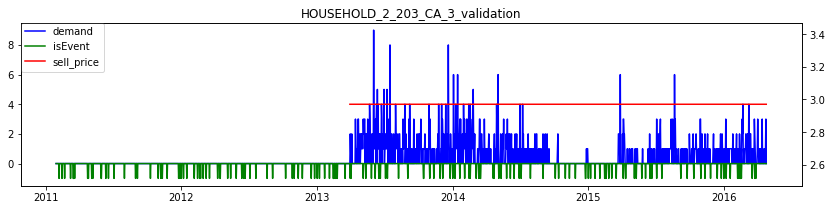

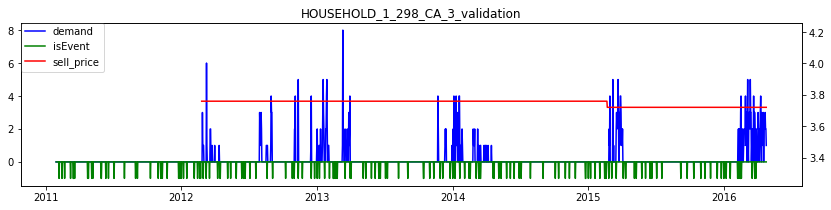

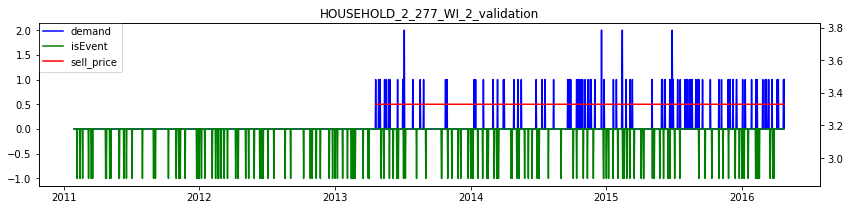

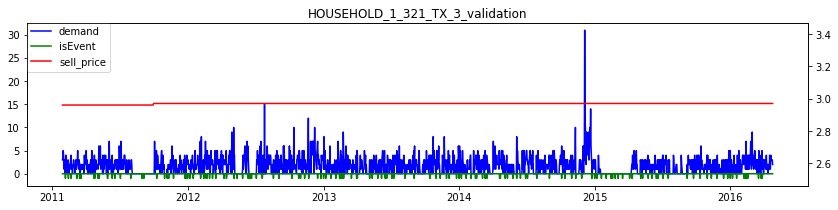

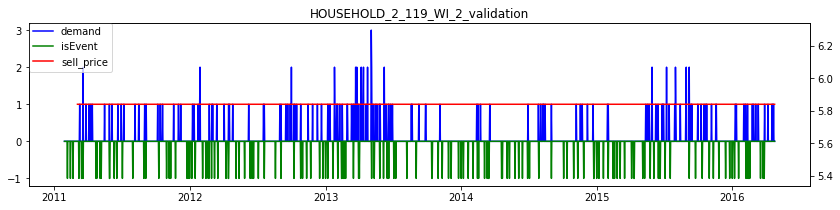

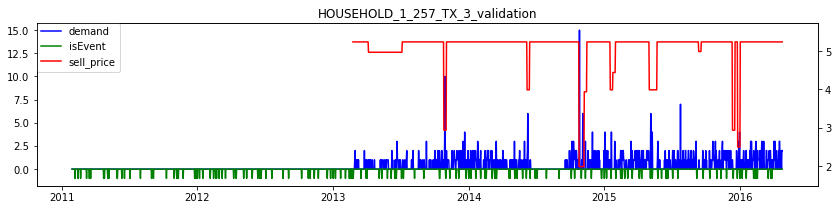

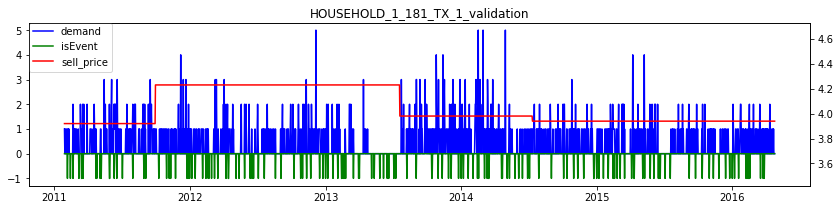

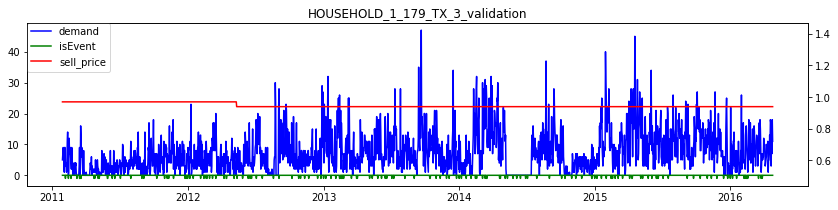

In [26]:
household_id = [id for id in ids if 'HOUSEHOLD' in id]
for i in range(len(household_id)):
    r = np.random.randint(1, len(household_id))
    plot(train, household_id[r])
    if i == 50:
        break

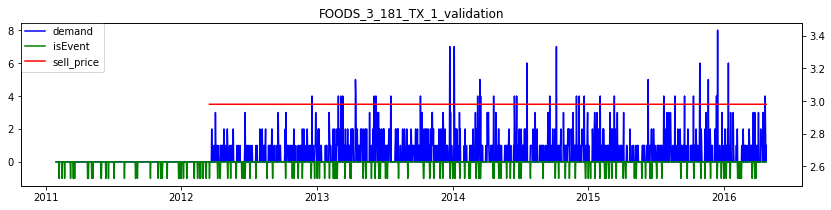

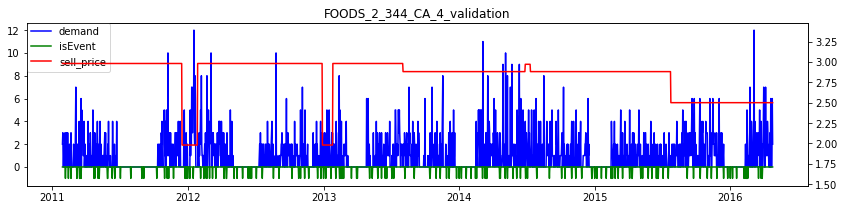

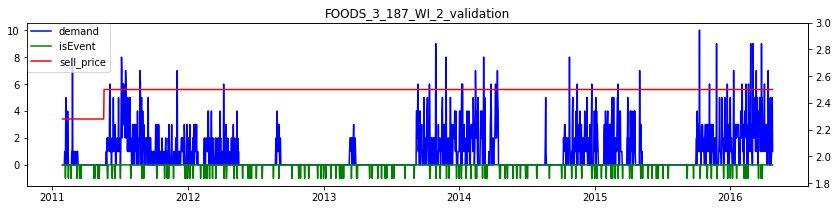

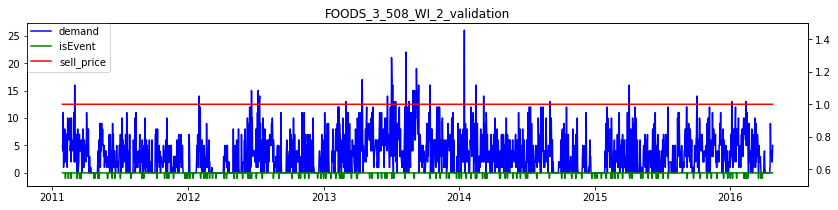

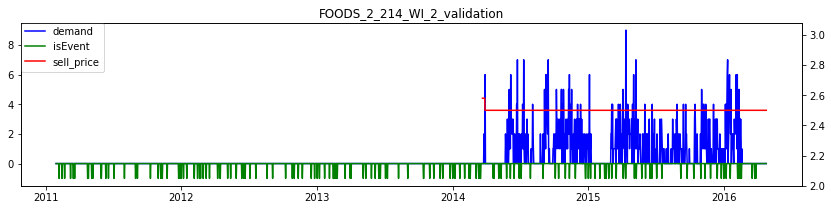

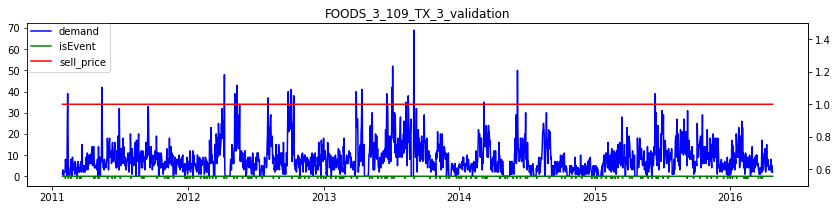

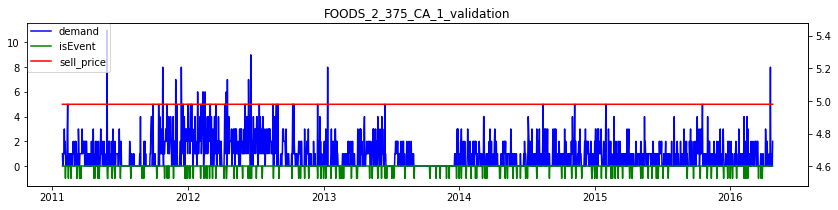

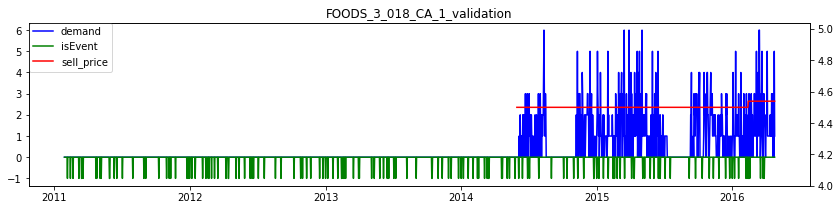

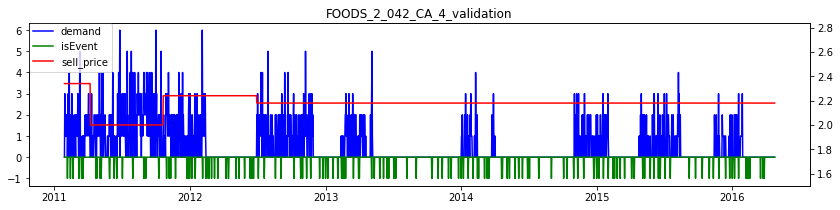

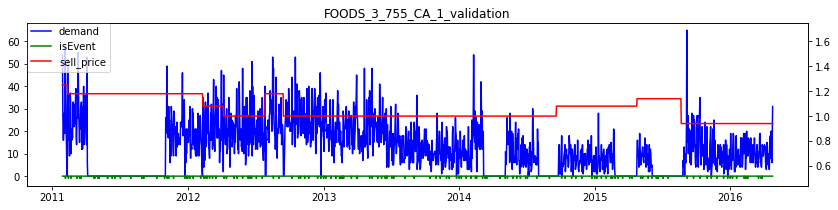

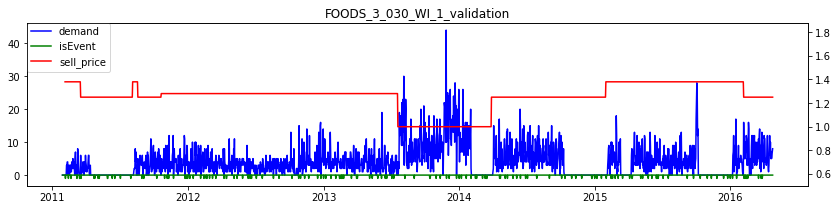

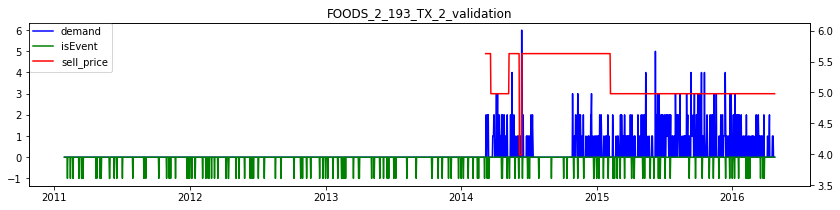

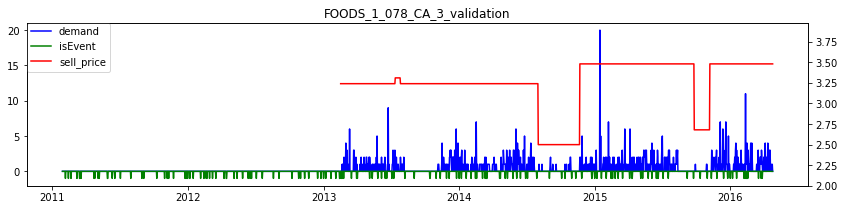

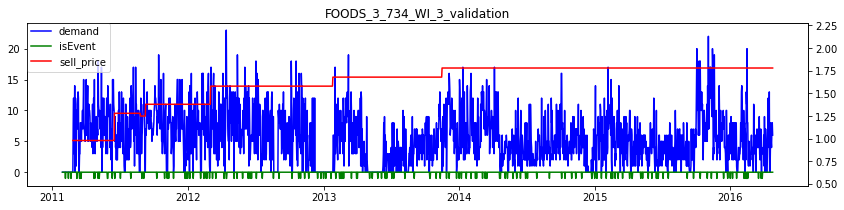

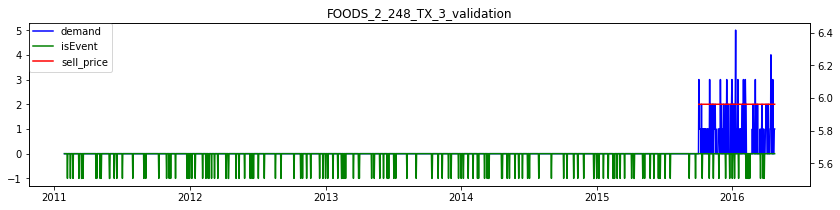

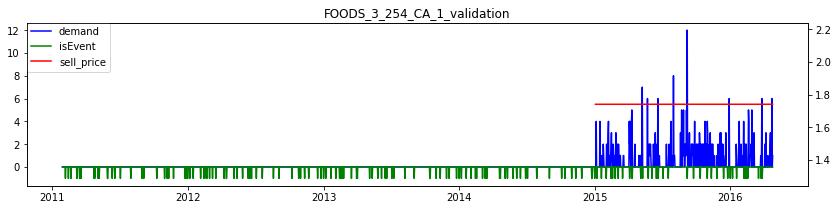

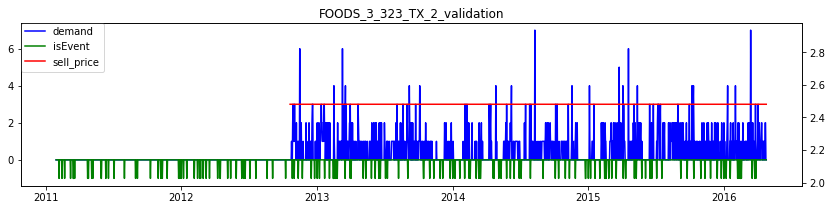

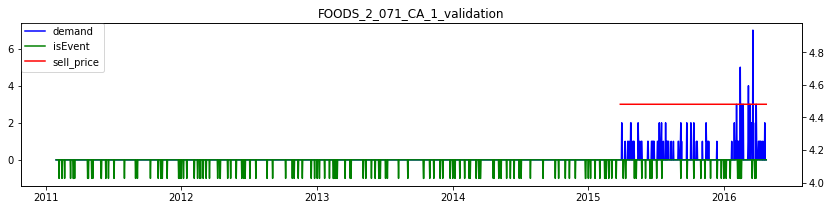

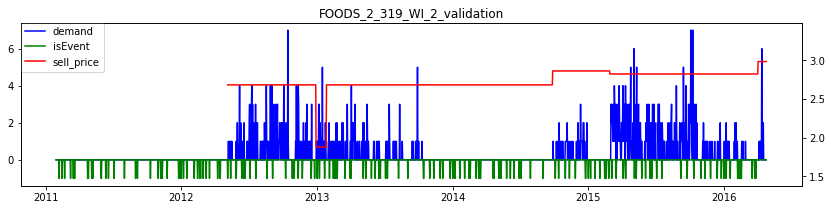

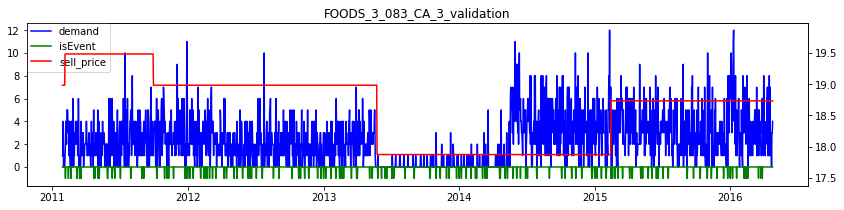

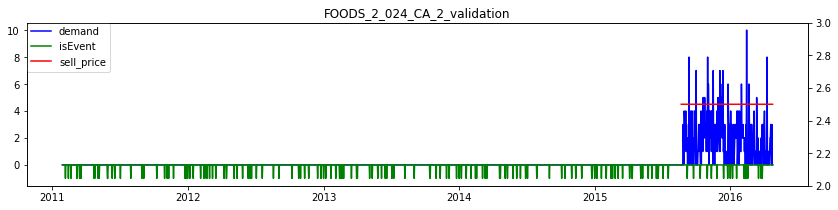

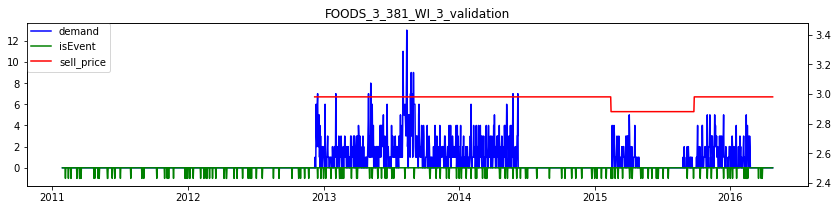

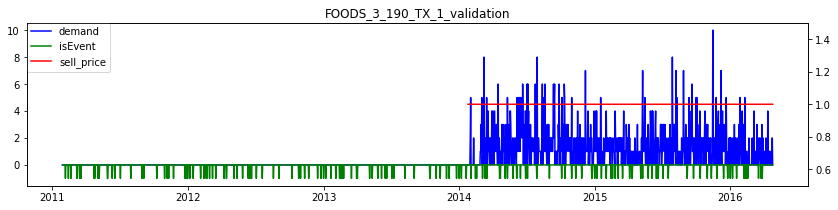

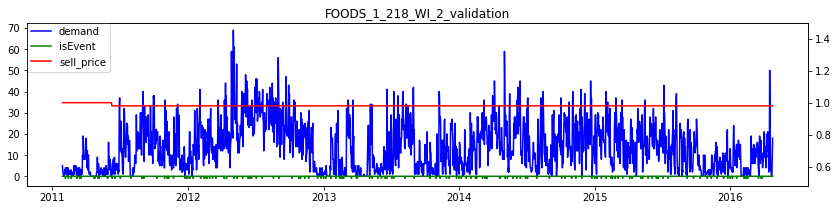

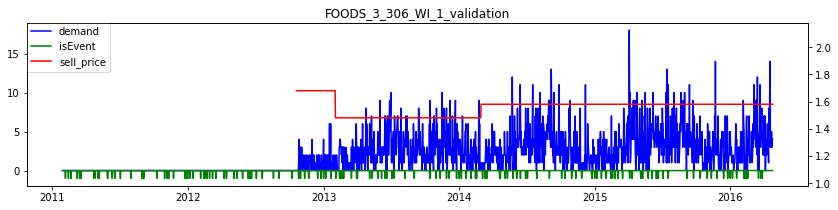

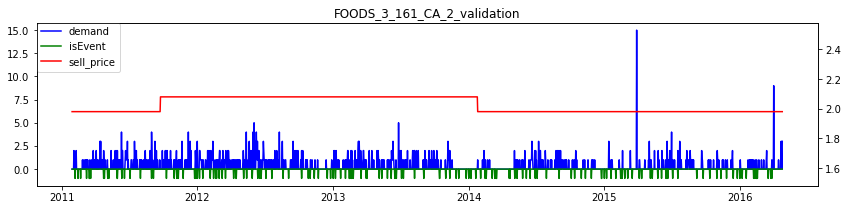

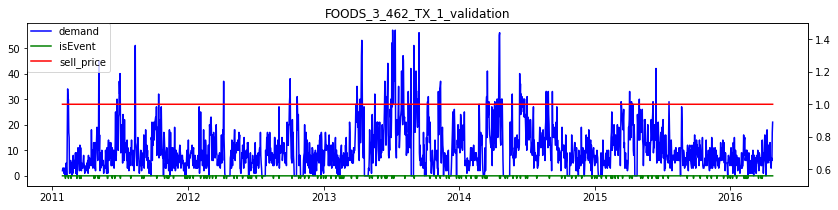

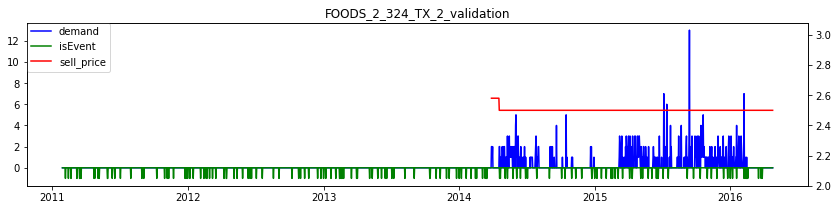

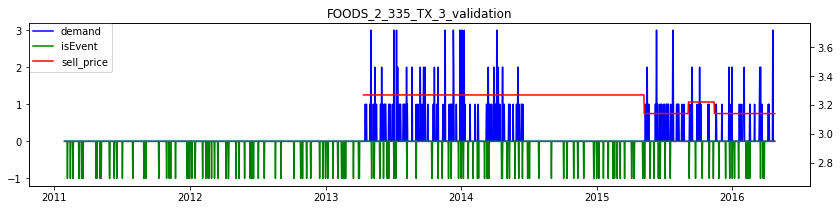

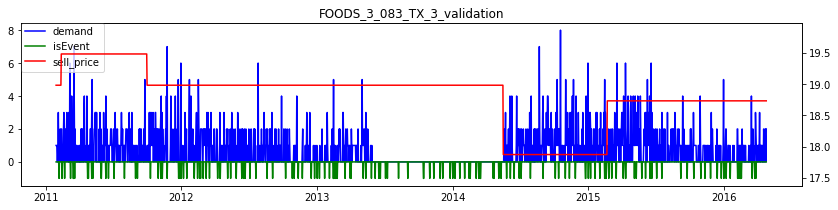

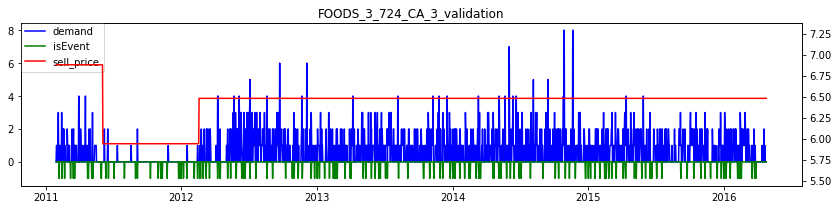

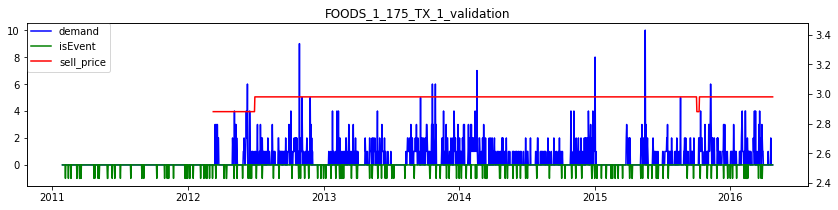

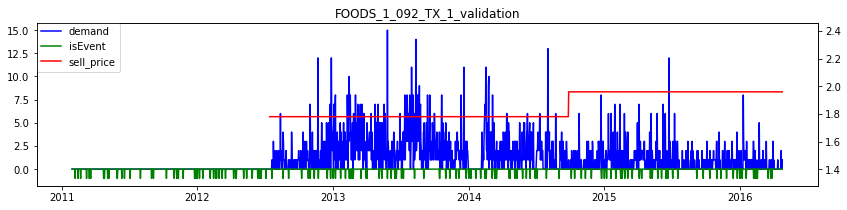

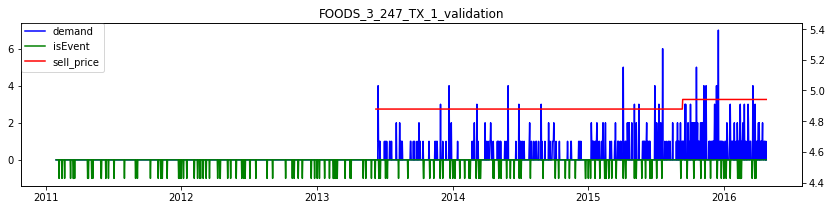

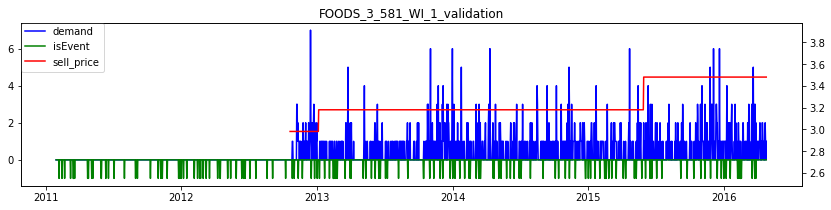

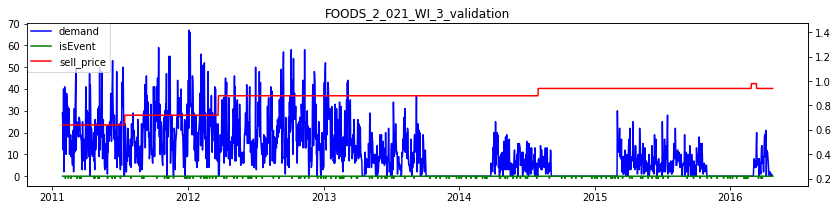

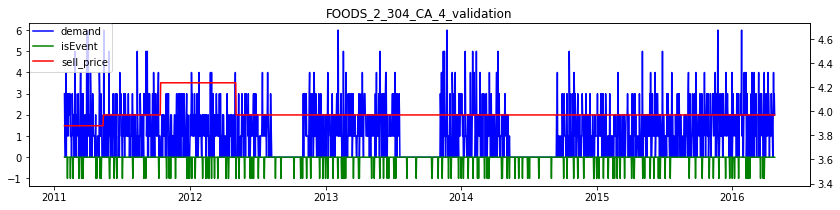

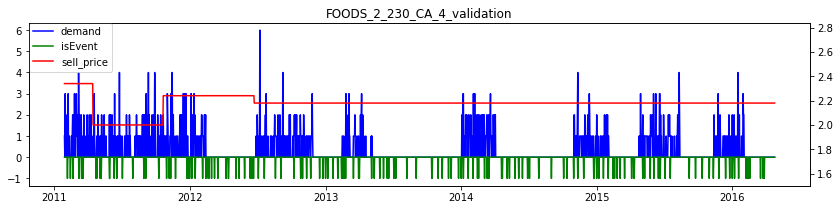

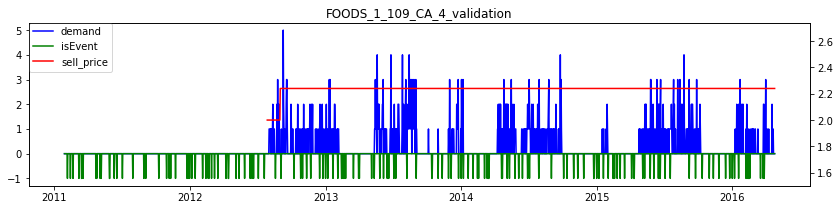

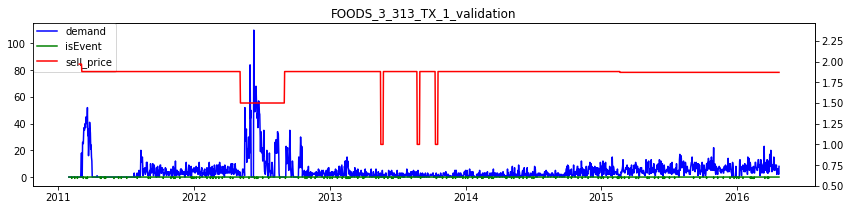

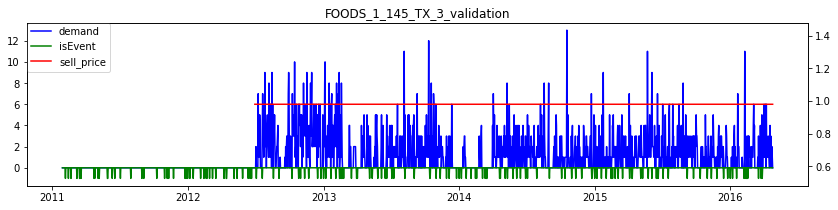

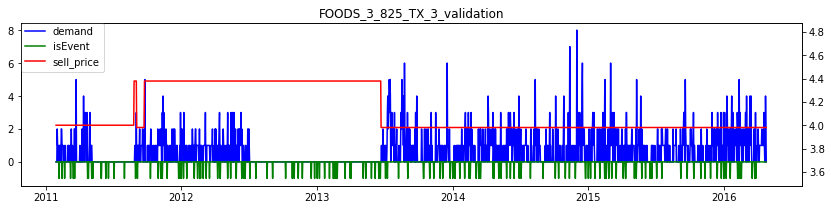

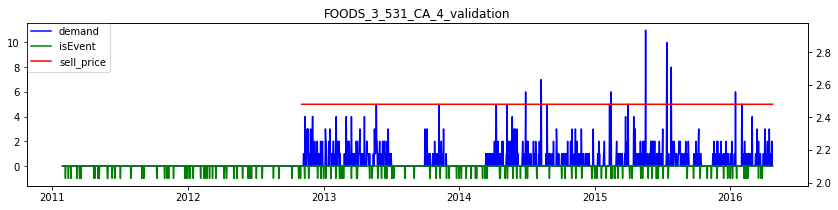

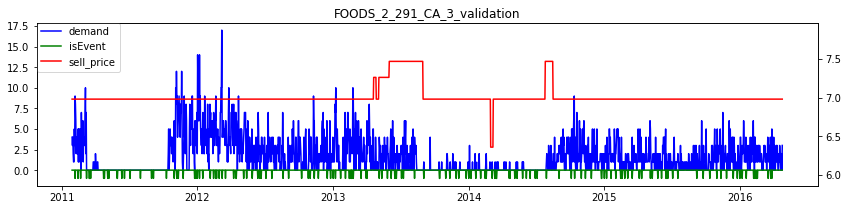

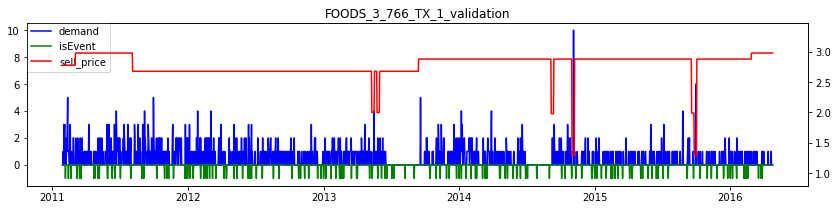

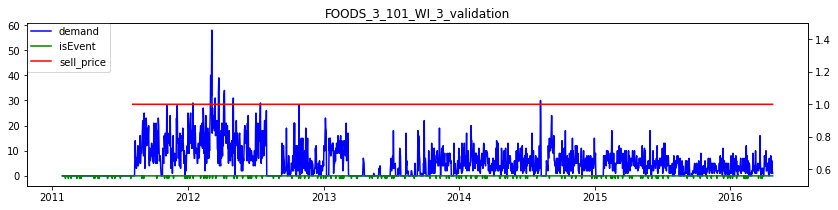

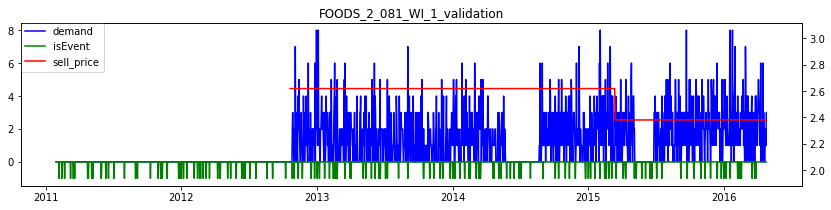

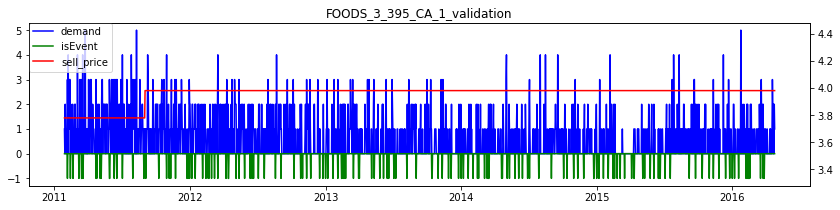

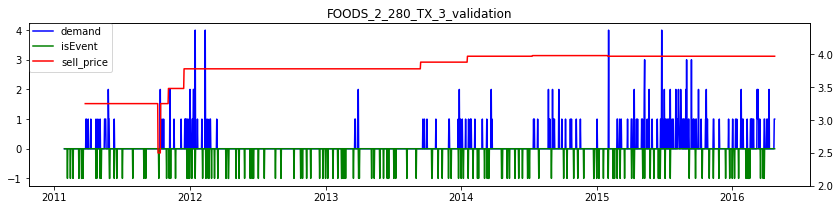

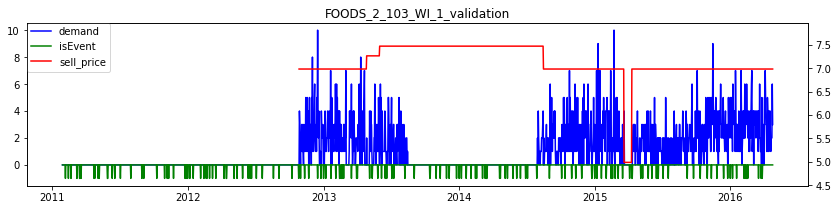

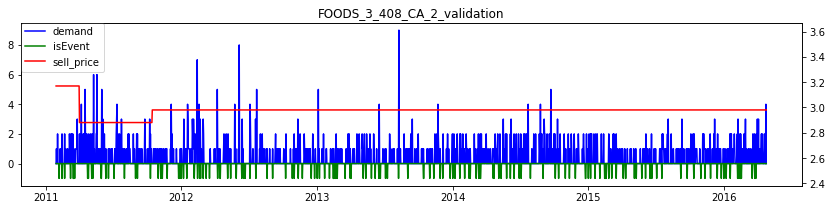

In [27]:
foods_id = [id for id in ids if 'FOODS' in id]
for i in range(len(foods_id)):
    r = np.random.randint(1, len(foods_id))
    plot(train, foods_id[r])
    if i == 50:
        break

---
Extermine Item

In [92]:
_df = train.dropna()[['id', 'date']]

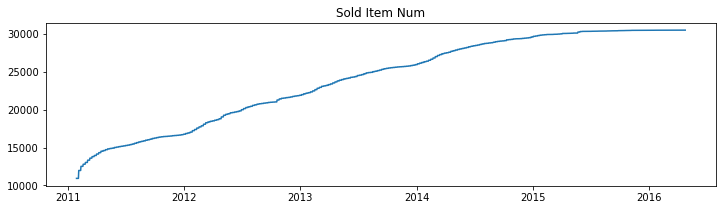

In [93]:
# 最初は11000件の商品しか販売されていない
group = _df.groupby('date').count().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
plt.plot(group['date'], group['id'])
plt.title('Sold Item Num')
plt.show()

In [94]:
# 販売開始しているのは店舗によって異なる
# 販売開始前の商品でも別店舗の売上データを活用できるかも
group = _df.groupby('id').count().reset_index()
group = group.sort_values(by=['date', 'id'], ascending=True)
print('Max of Date: ', group['date'].max())
group.head(10)

Max of Date:  1913


id  date
12070      FOODS_3_595_CA_1_validation    72
12072      FOODS_3_595_CA_3_validation    72
20218  HOUSEHOLD_1_020_WI_2_validation    72
22732  HOUSEHOLD_1_278_CA_3_validation    72
23061  HOUSEHOLD_1_311_CA_2_validation    72
23807  HOUSEHOLD_1_386_WI_1_validation    72
23923  HOUSEHOLD_1_400_CA_4_validation    72
23971  HOUSEHOLD_1_405_CA_2_validation    72
9083       FOODS_3_296_CA_4_validation    86
23928  HOUSEHOLD_1_400_WI_2_validation    86

In [98]:
_dict = {k:v for k, v in zip(group['id'].values, group['date'].values)}
train['aaa'] = train['id'].map(_dict)
train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  demand   part       date  wm_yr_wk event_name_1 event_type_1  \
0       CA       0  train 2011-01-29     11101       Nodata       Nodata   
1       CA       0  train 2011-01-29     11101       Nodata       Nodata   
2       CA       0  train 2011-01-29     11101       Nodata       Nodata   
3       CA       0  train 2011-01-29     11101       Nodata       Nodata   
4       CA       0  train 2011-01-29     11101       Nodata       Nodata   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  year  \
0       Nodata       Nodata        0        0        0         NaN  2011   
1       Nodata       Nodata        0        0        0         NaN  2011   
2       Nodata       Nodata        0        0        0         NaN  2011   
3       Nodata       Nodata        0        0        0         NaN  2011   
4       Nodata       Nodata        0        0        0         NaN  2011   

   month  weekday  event_name_1_l  event_type_1_l  event_name_2_l  \
0      1        5               0               0               0   
1      1        5               0               0               0   
2      1        5               0               0               0   
3      1        5               0               0               0   
4      1        5               0               0               0   

   event_type_2_l   aaa  
0               0  1017  
1               0  1773  
2               0   814  
3               0  1878  
4               0  1801

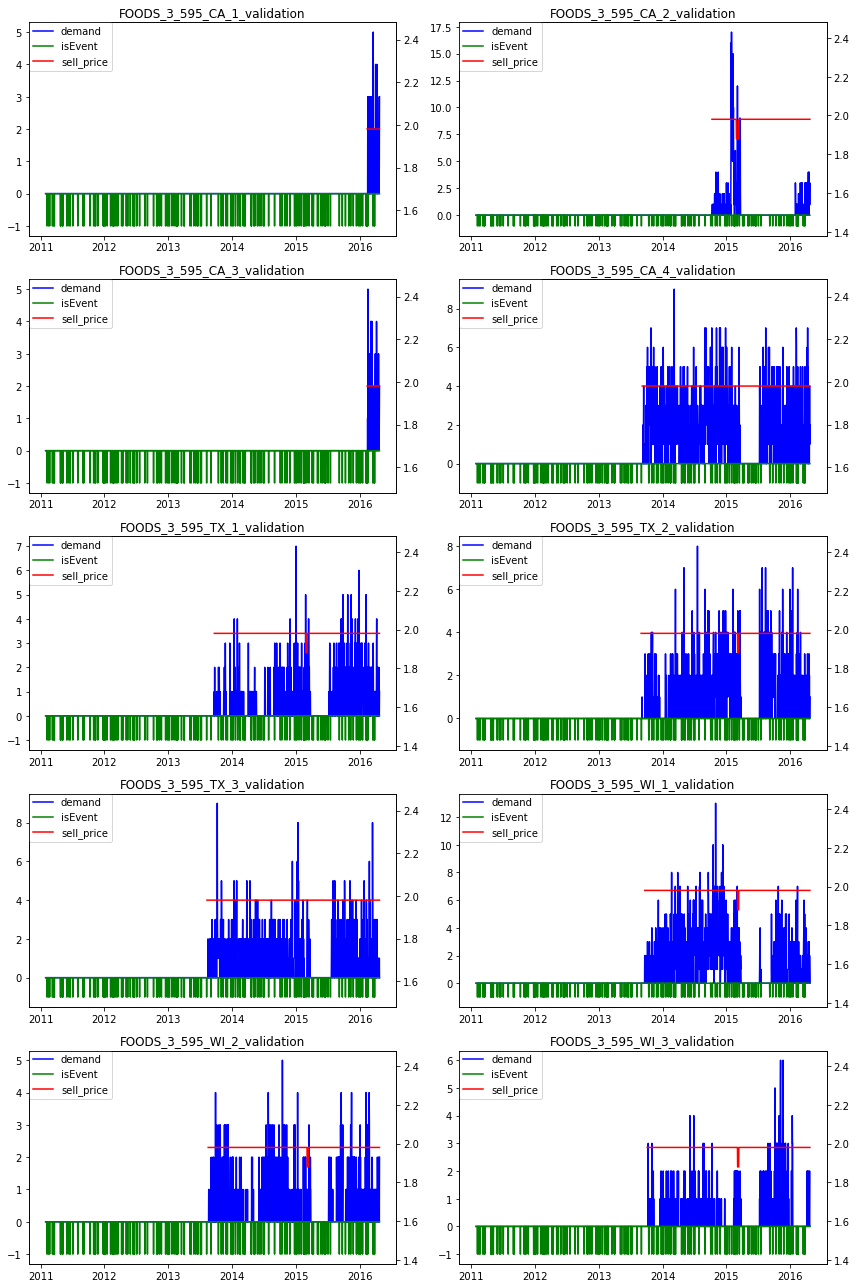

In [90]:
plot_per_item(train, 'FOODS_3_595')

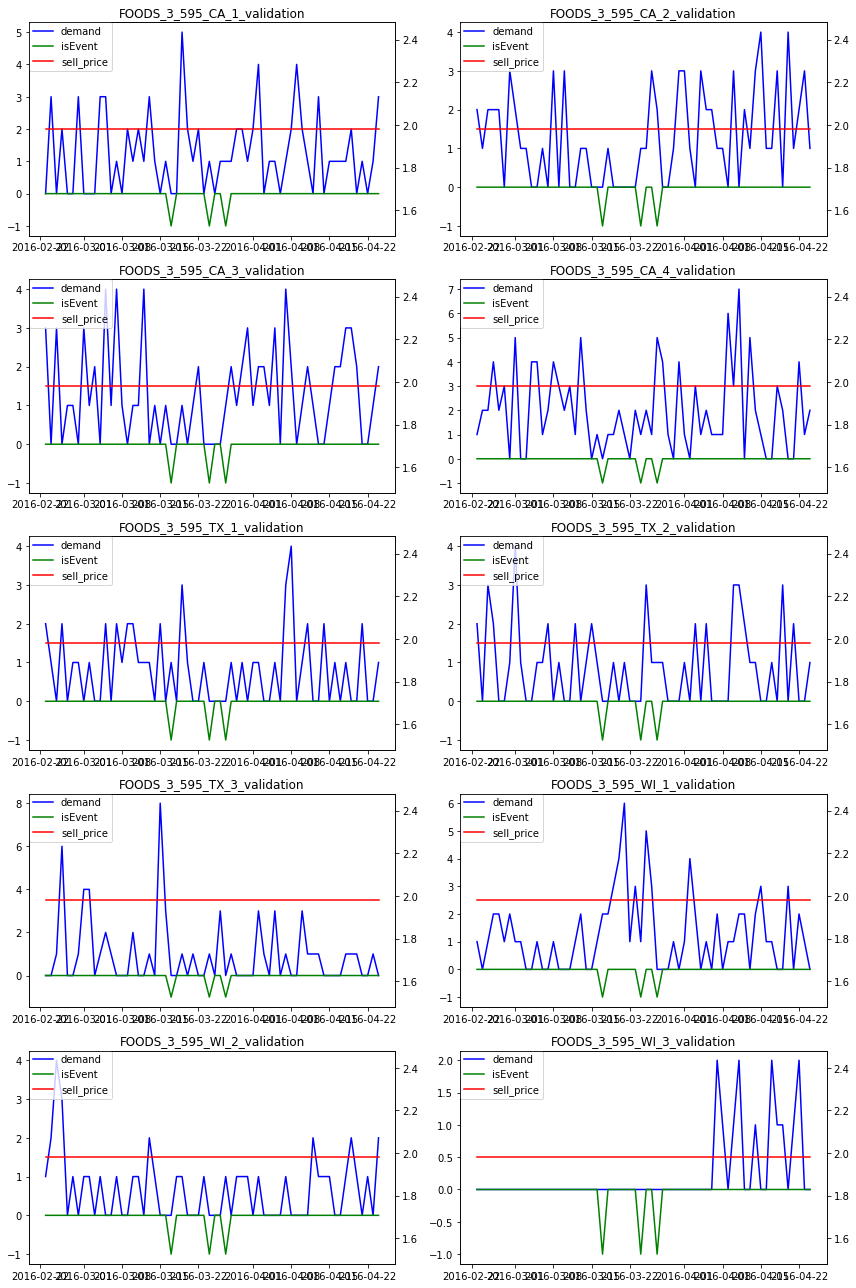

In [91]:
# 全店舗で販売していた期間のみ抽出
plot_per_item(train[train['date'] >= '2016/02/23'], 'FOODS_3_595')

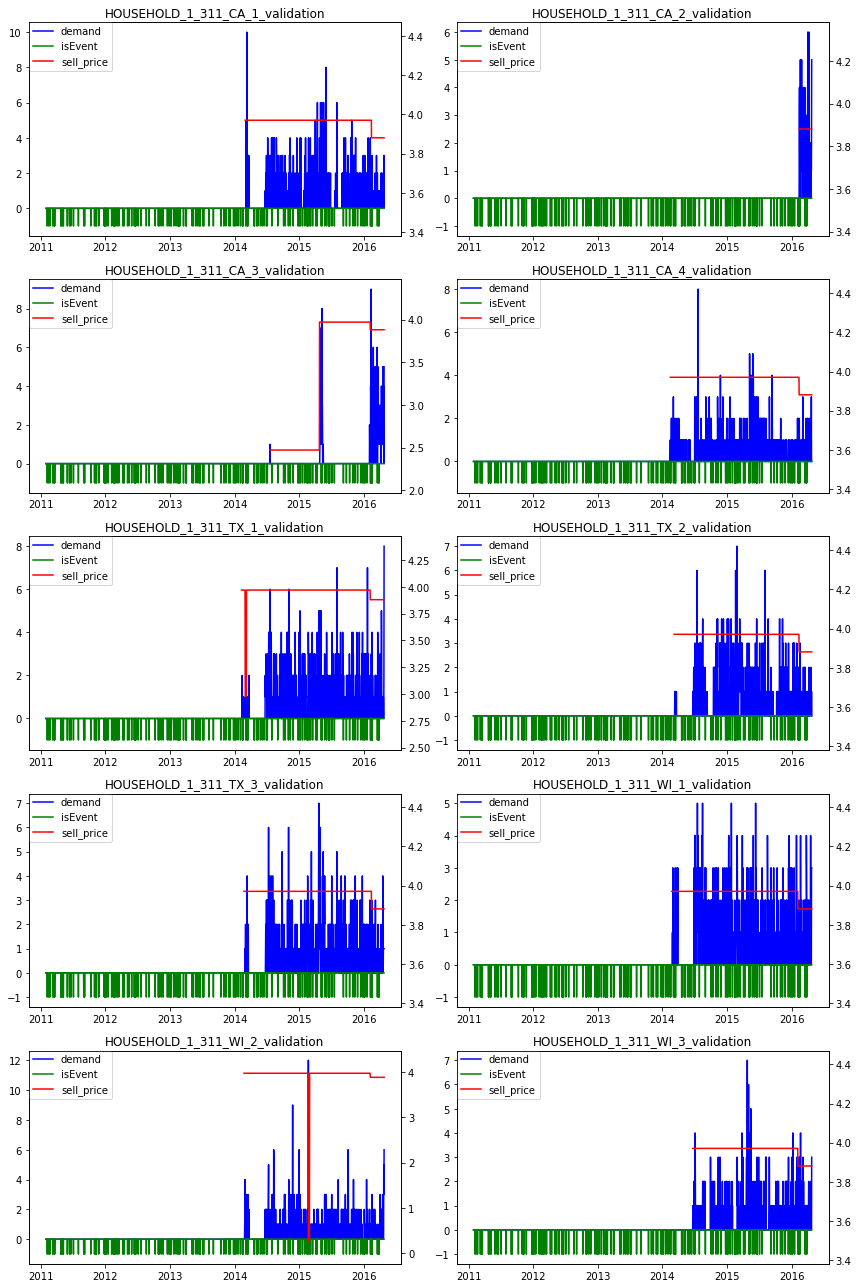

In [32]:
plot_per_item(train, 'HOUSEHOLD_1_311')

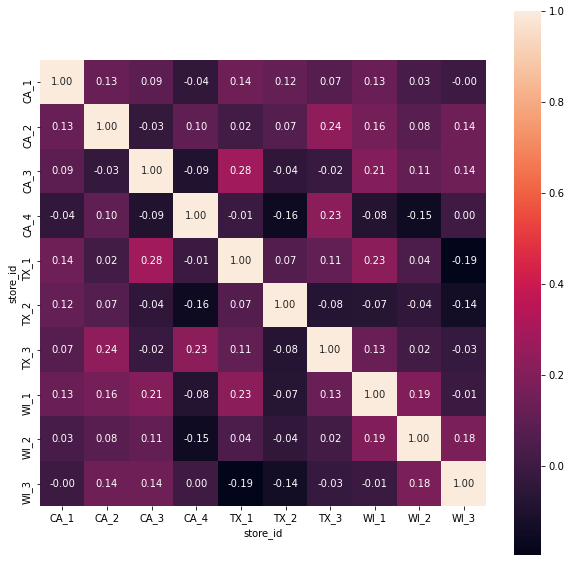

In [33]:
# ある特定のアイテムにおいて、店舗ごとの売上相関を見る
# 全然相関高くないのでそのまま当てはめられない
temp = train[train['item_id'] == 'HOUSEHOLD_1_020']
temp = temp.groupby(['store_id', 'date'])['demand'].mean().reset_index()
temp = pd.pivot(temp, index='date', columns='store_id', values='demand')

# temp = temp.replace(0, np.nan)
# temp.dropna(inplace=True, how='all')
temp = temp.iloc[-72:]
temp.shape

temp = temp.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(temp, annot=True, fmt='.2f', square=True)
plt.show()

---
item_id

In [34]:
temp = train.dropna()[['item_id', 'demand']]
temp = temp.groupby('item_id')['demand'].agg(['min', 'max', 'count', 'mean', 'median', 'std']).reset_index()
temp['item'] = temp['item_id'].apply(lambda x: x.split('_')[0])
temp.head()

item_id  min  max  count      mean  median       std   item
0  FOODS_1_001    0   24  19123  0.640433       0  1.319751  FOODS
1  FOODS_1_002    0    8  19123  0.383517       0  0.760427  FOODS
2  FOODS_1_003    0   22  19130  0.700157       0  1.257818  FOODS
3  FOODS_1_004    0  116  15140  8.552246       6  8.584537  FOODS
4  FOODS_1_005    0   30  19109  1.199121       0  2.248477  FOODS

---
標準偏差ごとに波形を見てみる

In [35]:
# 標準偏差
_temp = temp.sort_values(by='std', ascending=False)
_temp.head(10)

item_id  min  max  count       mean  median        std   item
702   FOODS_3_090    0  763  19130  52.406116      38  61.204986  FOODS
1198  FOODS_3_586    0  237  19130  48.104652      42  32.892232  FOODS
732   FOODS_3_120    0  276  14909  18.988799       9  26.658199  FOODS
864   FOODS_3_252    0  184  19130  29.550392      25  22.218959  FOODS
930   FOODS_3_318    0  436  19130  13.622478       8  20.976239  FOODS
846   FOODS_3_234    0  323  19067  13.172497       6  20.712806  FOODS
1153  FOODS_3_541    0  306  19130  14.251124       8  19.792923  FOODS
1247  FOODS_3_635    0  355  19060  14.802413       8  19.787082  FOODS
1417  FOODS_3_808    0  329  19067  14.783605       9  19.368463  FOODS
1199  FOODS_3_587    0  154  19130  20.706691      18  18.701665  FOODS

In [36]:
_temp = temp.sort_values(by='std', ascending=True)
_temp.head(10)

item_id  min  max  count      mean  median       std       item
1971    HOBBIES_2_119    0    4  18052  0.036561       0  0.193500    HOBBIES
2924  HOUSEHOLD_2_392    0    3  16722  0.053522       0  0.240494  HOUSEHOLD
2620  HOUSEHOLD_2_087    0    4  18787  0.055730       0  0.245545  HOUSEHOLD
2575  HOUSEHOLD_2_042    0    3  19081  0.056601       0  0.249829  HOUSEHOLD
2680  HOUSEHOLD_2_147    0    3  18899  0.061114       0  0.254124  HOUSEHOLD
1642    HOBBIES_1_212    0    3  16162  0.058347       0  0.254406    HOBBIES
2606  HOUSEHOLD_2_073    0    4  15371  0.059918       0  0.254538  HOUSEHOLD
2551  HOUSEHOLD_2_018    0    4  19011  0.061017       0  0.256962  HOUSEHOLD
1488    HOBBIES_1_052    0    5  14979  0.059684       0  0.258988    HOBBIES
2619  HOUSEHOLD_2_086    0    6  15315  0.062618       0  0.264941  HOUSEHOLD

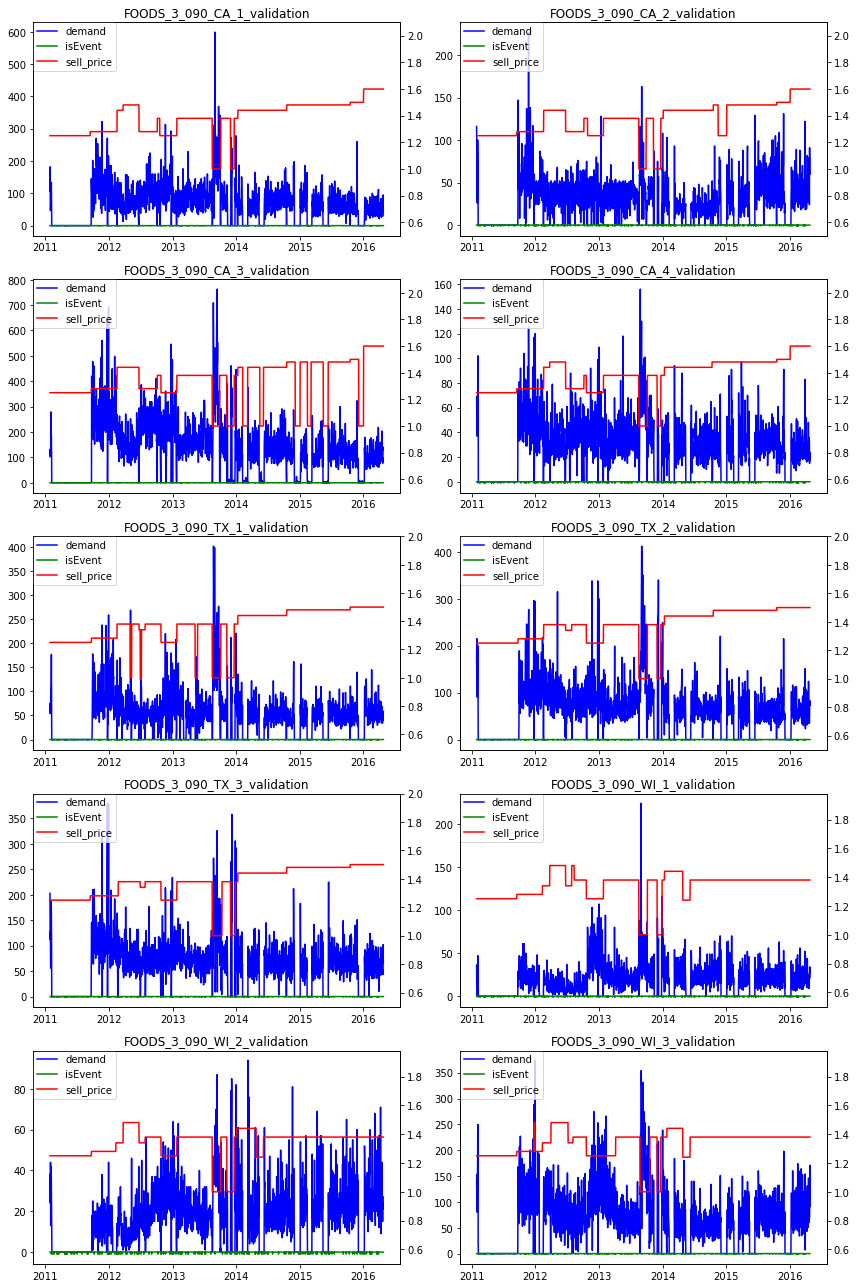

In [102]:
# 標準偏差が大きい例
plot_per_item(train, 'FOODS_3_090')

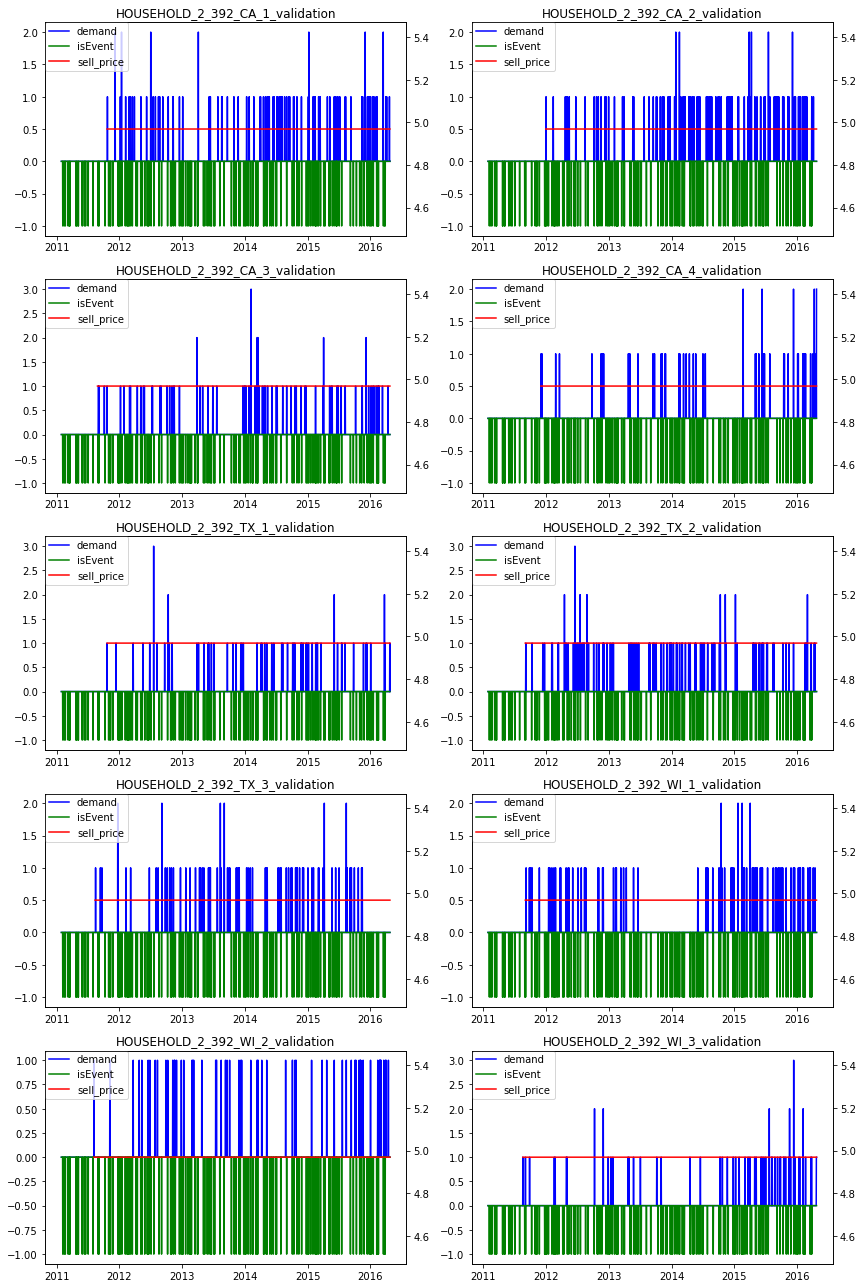

In [38]:
# 標準偏差が小さい例
plot_per_item(train, 'HOUSEHOLD_2_392')

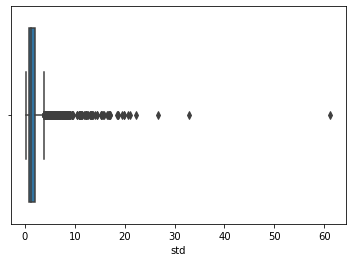

In [39]:
sns.boxplot(temp['std'])
plt.show()

In [40]:
# 標準偏差が平均くらいのもの
_temp = temp[temp['std'] < temp['std'].mean()]
_temp = _temp.sort_values(by='std', ascending=False)
_temp.head()

item_id  min  max  count      mean  median       std       item
1121      FOODS_3_509    0   22  12851  1.455607       1  1.864838      FOODS
130       FOODS_1_133    0   87  18969  0.651062       0  1.864016      FOODS
491       FOODS_2_277    0   56   6915  0.785539       0  1.862769      FOODS
2403  HOUSEHOLD_1_411    0   16  18577  1.765786       1  1.862464  HOUSEHOLD
647       FOODS_3_034    0   41   9764  1.786051       1  1.862091      FOODS

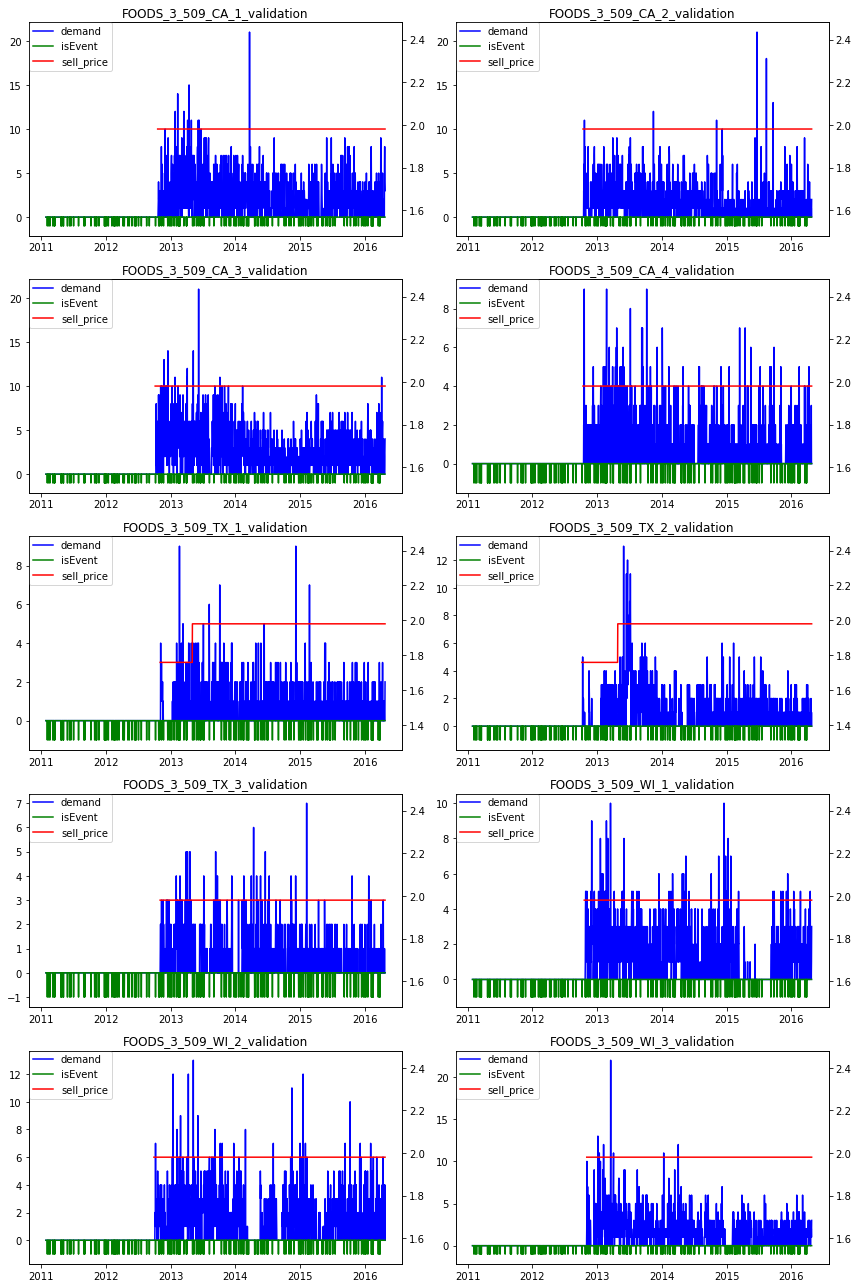

In [41]:
# 標準偏差が平均くらいの例
plot_per_item(train, 'FOODS_3_509')

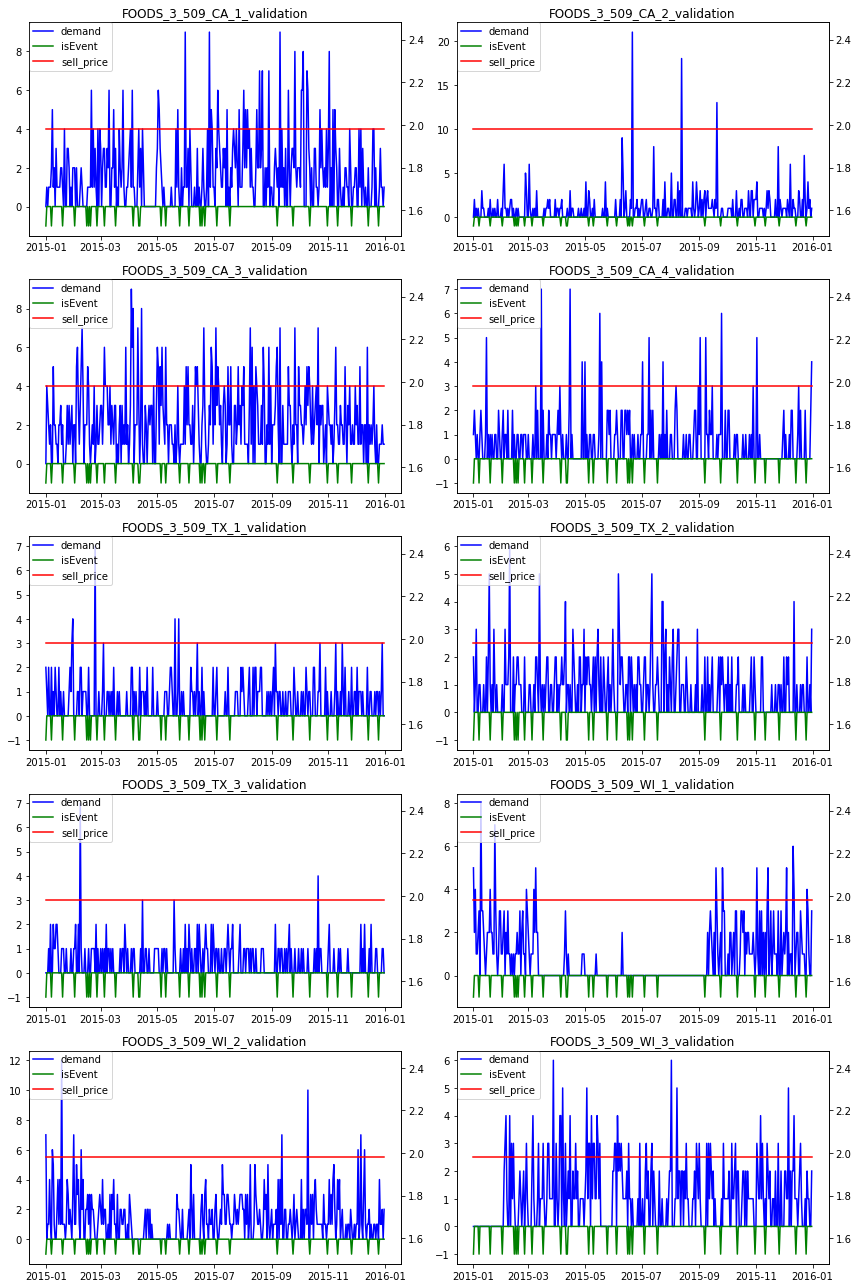

In [42]:
# 標準偏差が平均くらいの例
plot_per_item(train[train['year'] == 2015], 'FOODS_3_509')

---
### Correlation per dept_id
特定の店舗に絞って商品ごとの売上数推移の相関を見てみる

In [65]:
# ある特定の店に絞って全商品の購買数の相関を見てみる
# 2016/02/23以降がすべての商品が売られている
temp = train[(train['store_id'] == 'CA_1') & (train['cat_id'] == 'FOODS') & (train['date'] >= "2016/02/23")]
temp = pd.pivot(temp, index='date', columns='item_id', values='demand')
temp = temp.corr()
temp.head()

item_id      FOODS_1_001  FOODS_1_002  FOODS_1_003  FOODS_1_004  FOODS_1_005  \
item_id                                                                        
FOODS_1_001     1.000000     0.151448     0.159922          NaN     0.127817   
FOODS_1_002     0.151448     1.000000    -0.065261          NaN     0.151135   
FOODS_1_003     0.159922    -0.065261     1.000000          NaN     0.134573   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005     0.127817     0.151135     0.134573          NaN     1.000000   

item_id      FOODS_1_006  FOODS_1_008  FOODS_1_009  FOODS_1_010  FOODS_1_011  \
item_id                                                                        
FOODS_1_001    -0.021060     0.141072          NaN     0.127896     0.005925   
FOODS_1_002     0.141024     0.006041          NaN    -0.008671     0.166461   
FOODS_1_003     0.040850    -0.132038          NaN    -0.090255    -0.078493   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005    -0.167816    -0.068714          NaN     0.211884     0.000722   

item_id      FOODS_1_012  FOODS_1_013  FOODS_1_014  FOODS_1_015  FOODS_1_016  \
item_id                                                                        
FOODS_1_001    -0.038133     0.002841    -0.000562     0.041207    -0.311393   
FOODS_1_002    -0.143981    -0.264070    -0.064963     0.047559    -0.177339   
FOODS_1_003     0.094201     0.071736    -0.223490    -0.083586    -0.202167   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005     0.139422     0.220344     0.169356    -0.069198    -0.014231   

item_id      FOODS_1_017  FOODS_1_018  FOODS_1_019  FOODS_1_020  FOODS_1_021  \
item_id                                                                        
FOODS_1_001    -0.256157    -0.061421     0.064408    -0.184366    -0.028085   
FOODS_1_002    -0.074135    -0.160674     0.073385    -0.014224     0.112257   
FOODS_1_003    -0.231210    -0.081277    -0.155721    -0.106327    -0.046072   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005     0.233674     0.209263     0.236427     0.223721     0.281443   

item_id      FOODS_1_022  FOODS_1_023  FOODS_1_024  FOODS_1_025  FOODS_1_026  \
item_id                                                                        
FOODS_1_001    -0.073913    -0.019784    -0.025982     0.198099     0.073422   
FOODS_1_002     0.022272    -0.142968    -0.033572    -0.070482     0.443610   
FOODS_1_003     0.136001     0.181989     0.292495    -0.147376     0.095111   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005     0.037533     0.039358     0.030034     0.192155     0.166996   

item_id      FOODS_1_027  FOODS_1_028  FOODS_1_029  FOODS_1_030  FOODS_1_031  \
item_id                                                                        
FOODS_1_001    -0.132145     0.100132     0.100161    -0.159047    -0.167250   
FOODS_1_002    -0.105110     0.408606     0.126391     0.174556    -0.115805   
FOODS_1_003    -0.082262     0.014206    -0.151174    -0.247375     0.091133   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005     0.048530     0.005271     0.039236    -0.159522     0.089003   

item_id      FOODS_1_032  FOODS_1_033  FOODS_1_034  FOODS_1_035  FOODS_1_036  \
item_id                                                                        
FOODS_1_001    -0.073695    -0.079865     0.069161    -0.040226    -0.078020   
FOODS_1_002    -0.113572     0.060696    -0.047442    -0.092844     0.150686   
FOODS_1_003    -0.194823    -0.004320     0.146993     0.043691    -0.075490   
FOODS_1_004          NaN          NaN          NaN          NaN          NaN   
FOODS_1_005    -0.066585     0.170041     0.073752     0.041763     0.097374   

item_id      FOODS_1_037  FOODS_1_038  FOODS_1_039  FOODS_1_040  FOODS_1_

In [68]:
_temp = pd.DataFrame(temp.loc['FOODS_1_040', :]).reset_index()
_temp.sort_values(by='FOODS_1_040', ascending=False).head()

item_id  FOODS_1_040
38    FOODS_1_040     1.000000
497   FOODS_2_283     0.444085
1387  FOODS_3_778     0.438115
170   FOODS_1_174     0.380673
652   FOODS_3_039     0.377243

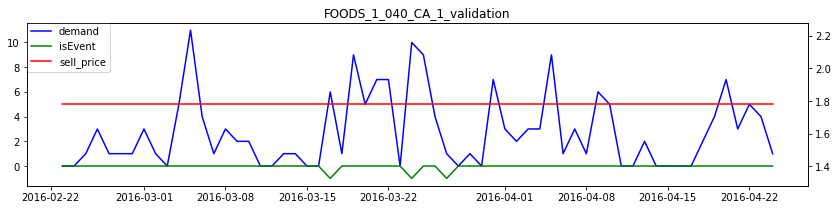

In [71]:
plot(train[train['date'] >= '2016/02/23'], 'FOODS_1_040_CA_1_validation')

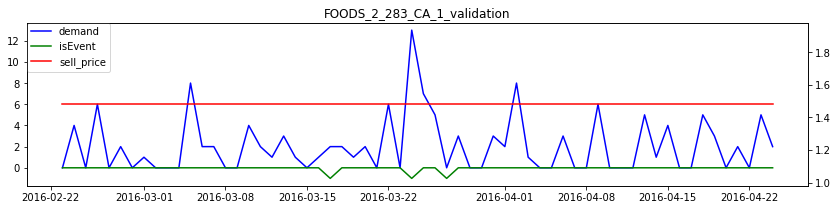

In [72]:
plot(train[train['date'] >= '2016/02/23'], 'FOODS_2_283_CA_1_validation')

In [56]:
# ある特定の店に絞って全商品の購買数の相関を見てみる
temp = train[(train['store_id'] == 'CA_2') & (train['cat_id'] == 'FOODS')]
temp = pd.pivot(temp, index='date', columns='item_id', values='demand')
temp = temp.corr()

_temp = pd.DataFrame(temp.loc['FOODS_3_595', :]).reset_index()
_temp.sort_values(by='FOODS_3_595', ascending=False).head()

item_id  FOODS_3_595
1207  FOODS_3_595     1.000000
779   FOODS_3_167     0.440743
175   FOODS_1_179     0.351935
737   FOODS_3_125     0.305978
1048  FOODS_3_436     0.297497

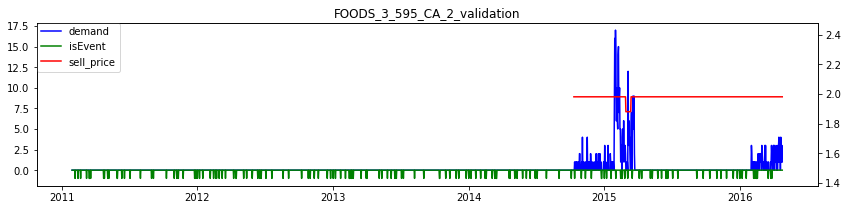

In [57]:
plot(train, 'FOODS_3_595_CA_2_validation')

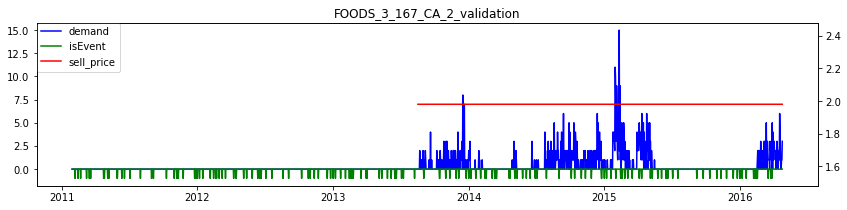

In [58]:
plot(train, 'FOODS_3_167_CA_2_validation')

In [77]:
tt = train.dropna().groupby('id')[['demand', 'sell_price']].mean().reset_index()
tt['cat'] = tt['id'].apply(lambda x: x.split('_')[0])
tt['state'] = tt['id'].apply(lambda x: x.split('_')[3])
tt.head()

id    demand  sell_price    cat
0  FOODS_1_001_CA_1_validation  0.785677    2.167969  FOODS
1  FOODS_1_001_CA_2_validation  1.157344    2.167969  FOODS
2  FOODS_1_001_CA_3_validation  1.203346    2.156250  FOODS
3  FOODS_1_001_CA_4_validation  0.359645    2.167969  FOODS
4  FOODS_1_001_TX_1_validation  0.584945    2.154297  FOODS

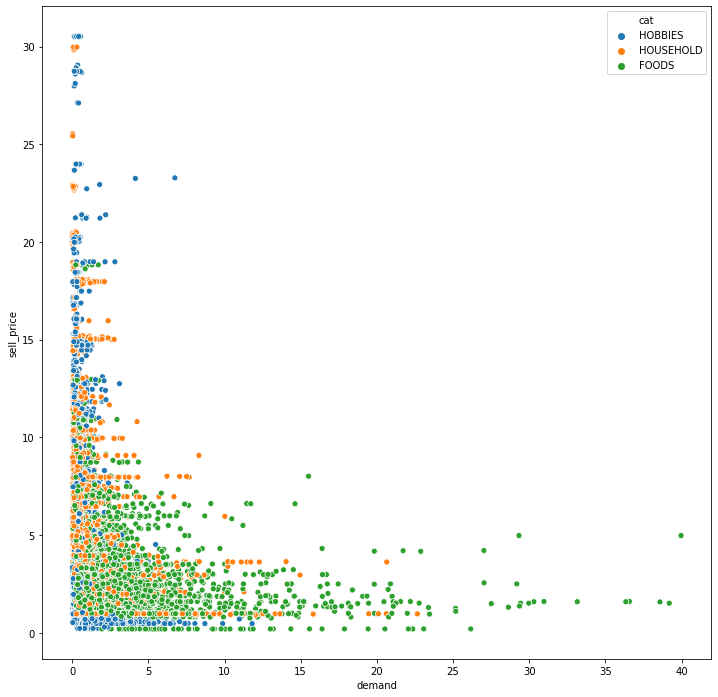

In [83]:
# 売上数と販売金額
# 食品は高い売上数で安い販売価格
# 他2つは少ない販売数で高い販売価格
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x='demand', y='sell_price', hue='cat', data=tt[tt['demand'] < 40].sample(frac=0.5))
plt.show()

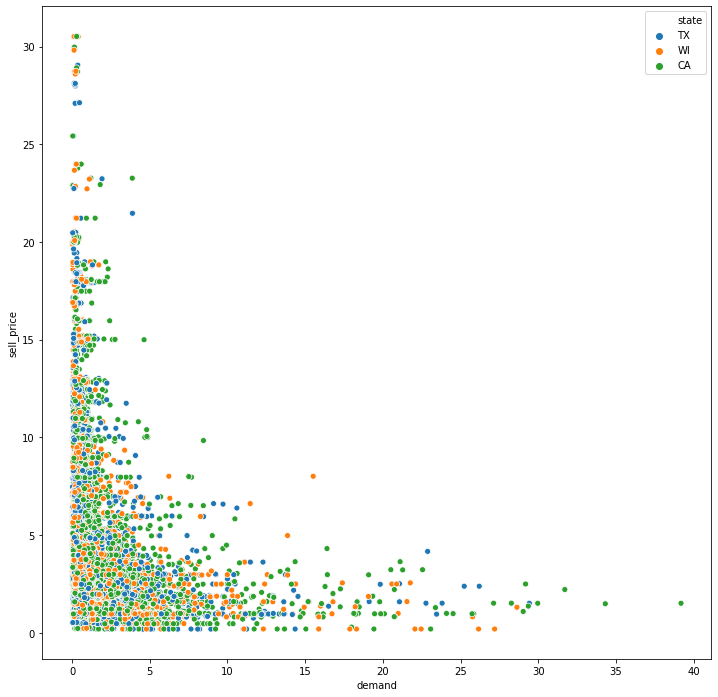

In [86]:
# 売上数と販売金額
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x='demand', y='sell_price', hue='state', data=tt[tt['demand'] < 40].sample(frac=0.5))
plt.show()

In [30]:
def th_func(x):
    x_d = x.shift(1)
    x_u = x.shift(-1)
    f = x_d + x_u
    if np.isnan(f) or f == 0:
        return np.nan
    else:
        return 1


train['flag'] = train.groupby('id')['demand'].transform(lambda x: x.shift(1)) - train.groupby('id')['demand'].transform(lambda x: x.shift(-1))

In [31]:
train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  demand   part       date  wm_yr_wk event_name_1 event_type_1  \
0       CA       0  train 2011-01-29     11101       Nodata       Nodata   
1       CA       0  train 2011-01-29     11101       Nodata       Nodata   
2       CA       0  train 2011-01-29     11101       Nodata       Nodata   
3       CA       0  train 2011-01-29     11101       Nodata       Nodata   
4       CA       0  train 2011-01-29     11101       Nodata       Nodata   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  year  \
0       Nodata       Nodata        0        0        0         NaN  2011   
1       Nodata       Nodata        0        0        0         NaN  2011   
2       Nodata       Nodata        0        0        0         NaN  2011   
3       Nodata       Nodata        0        0        0         NaN  2011   
4       Nodata       Nodata        0        0        0         NaN  2011   

   month  weekday  event_name_1_l  event_type_1_l  event_name_2_l  \
0      1        5               0               0               0   
1      1        5               0               0               0   
2      1        5               0               0               0   
3      1        5               0               0               0   
4      1        5               0               0               0   

   event_type_2_l  aaa  flag  
0               0  NaN   NaN  
1               0  NaN   NaN  
2               0  NaN   NaN  
3               0  NaN   NaN  
4               0  NaN   NaN

In [35]:
temp = train[train['id'] == 'FOODS_3_090_CA_1_validation']
temp = temp[temp['flag'] != 0]

In [48]:
train['percentile'] = train.groupby('id')['demand'].transform(lambda x: np.percentile(x, 99))
train['is_over_99'] = train['demand'] > train['percentile']
train['is_over_99'] = train['is_over_99'].apply(lambda x: 1 if x else 0)

In [ ]:
train.head()

In [44]:
np.percentile(train[train['id'] == 'HOBBIES_1_001_CA_1_validation']['demand'].values, 99)

3.0